<a href="https://colab.research.google.com/github/lukeawayne/FormerProjects/blob/main/Newfie/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing

In [1]:
!pip install pydicom
!pip install dicompyler-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.9 MB/s eta 0:00:00


In [2]:
import os
import matplotlib.pyplot as plt
import pydicom
from pydicom.dataset import Dataset
from dicompylercore import dicomparser, dvh, dvhcalc, dose
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib.patches import Polygon


from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Functions

In [3]:
#plotting DVH
def plot_dvh(file_path1, file_path2, structure_id):
    # Calculate the DVH for the given structure
    dvh = dvhcalc.get_dvh(file_path1, file_path2, structure_id)
    #adding names to structures
    #structure_name = structure_dictionary[structure_id]
    ds = pydicom.dcmread(file_path1)
    new_struct = structure_id - 1
    structure_name = ds.RTROIObservationsSequence[new_struct].RTROIIdentificationCodeSequence[0].CodeMeaning
    structure_name_list = ['Prostate', 'Rectum', 'Urinary bladder', 'Seminal vesicle', 'BOWel',
                           'Sigmoid colon', 'Planning target volume', 'Femur head & neck right',
                           'Femur head & neck left', 'Penile bulb']
    if structure_name in structure_name_list:
      # Extract the dose bin centers and cumulative counts
      dose_bins = dvh.bincenters
      volume_values_cumulative = dvh.counts
      # Convert absolute volume values to percentages
      total_volume = dvh.volume
      if total_volume == 0:
          print(f"Structure {structure_id} has a volume of 0!")
          #None
      volume_percent = (volume_values_cumulative / total_volume) * 100
      # Plot the DVH for this structure
      plt.plot(dose_bins, volume_percent, label=structure_name)
    else:
      None


#gathering files of interest
def file_list(DIR):
  #initilize list
  interest_list = []
  #finding Dose, Structure, and REG files
  for i in range(len(DIR.DirectoryRecordSequence)):
    if DIR.DirectoryRecordSequence[i].DirectoryRecordType != 'IMAGE':
      if 'Modality' in DIR.DirectoryRecordSequence[i]:
        if DIR.DirectoryRecordSequence[i].Modality != 'CT':
          if DIR.DirectoryRecordSequence[i].Modality == 'RTDOSE':
            interest_list.append(i)
          elif DIR.DirectoryRecordSequence[i].Modality == 'REG':
            interest_list.append(i)
          elif DIR.DirectoryRecordSequence[i].Modality == 'RTSTRUCT':
            interest_list.append(i+1)
  return interest_list

#creating dictionary of information
def DIR_informaiton(interest_list, DIR):
  #initializing dictionary
  main_dictionary = {}
  for i in range(len(interest_list)):
    file_number = i
    filei = interest_list[i]
    #setting standards in element missing
    Plan_type = 'N/A'
    Delivery_method = 'N/A'
    if 'Modality' in DIR.DirectoryRecordSequence[filei]:
      #finding file type
      #if DIR.DirectoryRecordSequence[filei].Modality == 'RTDOSE':
      File_type = DIR.DirectoryRecordSequence[filei].Modality
      #getting date
      Date = DIR.DirectoryRecordSequence[filei].SeriesDate
      File_time = DIR.DirectoryRecordSequence[filei].SeriesTime
      #File name
      File_name = DIR.DirectoryRecordSequence[filei+1].ReferencedFileID[1]
      #finding structures
      if 'DoseSummationType' in DIR.DirectoryRecordSequence[filei+1]:
        Delivery_method = DIR.DirectoryRecordSequence[filei+1].DoseSummationType
      #finding structures
    if DIR.DirectoryRecordSequence[filei].DirectoryRecordType == 'RT STRUCTURE SET':
        Plan_type = DIR.DirectoryRecordSequence[filei].StructureSetLabel
        File_type = 'RTSTRUCT'
        Date = DIR.DirectoryRecordSequence[filei].StructureSetDate
        File_time = DIR.DirectoryRecordSequence[filei].StructureSetTime
        File_name = DIR.DirectoryRecordSequence[filei].ReferencedFileID[1]
    #building dictionary
    dictionary = {'File Type': File_type, 'Date': int(Date),
                    'Time': File_time, 'File Name': File_name,
                    'Delivery Method': Delivery_method, 'Plan Type': Plan_type}
    #combining
    main_dictionary[file_number] = dictionary
  #sorting
  main_sorted = dict(sorted(main_dictionary.items(),
                key=lambda item: (item[1]['Date'], item[1]['File Type'],
                                  item[1]['Plan Type'], item[1]['Time'])))
  main_sorted = {i: main_sorted[key] for i, key in enumerate(main_sorted)}
  return main_sorted

#function for plotting structures y,z
def plot_rt_structure(file_path,reference_num,fraction):
    # Read DICOM RT Structure file
    ds = pydicom.dcmread(file_path)
    # Extract contour data
    contours = ds.ROIContourSequence
    # Plot contours on a 2D plot for the specified organ
    for contour in contours:
        if contour.ReferencedROINumber == reference_num:
            for contour_sequence in contour.ContourSequence:
                contour_data = contour_sequence.ContourData
                num_points = len(contour_data) // 3
                # Extract RGB color information from ROIDisplayColor
                roidisplaycolor = contour.ROIDisplayColor
                color = [float(c) / 255 for c in roidisplaycolor]
                # Extract points from contour data
                points = [(contour_data[i+1], contour_data[i+2]) for i in range(0, len(contour_data)-1, 3)]
                # Plot the contour on a 2D plot with different line styles or markers
                plt.gca().add_patch(Polygon(points, closed=True, fill=None, edgecolor=color))
    plt.axis('equal')
    plt.title(f'DICOM RT Structure Plot fx {fraction+1}')
    #plt.show()

#plotting x,y
def plot_rt_xy(file_path,reference_num):
    # Read DICOM RT Structure file
    ds = pydicom.dcmread(file_path)
    # Extract contour data
    contours = ds.ROIContourSequence
    # Plot contours on a 2D plot for the specified organ
    for contour in contours:
        if contour.ReferencedROINumber == reference_num:
            for contour_sequence in contour.ContourSequence:
                contour_data = contour_sequence.ContourData
                num_points = len(contour_data) // 3
                # Extract RGB color information from ROIDisplayColor
                roidisplaycolor = contour.ROIDisplayColor
                color = [float(c) / 255 for c in roidisplaycolor]
                # Extract points from contour data
                points = [(contour_data[i], contour_data[i+1]) for i in range(0, len(contour_data)-1, 3)]
                # Plot the contour on a 2D plot with different line styles or markers
                plt.gca().add_patch(Polygon(points, closed=True, fill=None, edgecolor=color))
                plt.axis('equal')
                plt.title(f'DICOM RT Structure Plot')
                #plt.show()

# Patient 1

In [82]:
pt1_path = '/content/drive/My Drive/DICOMData/Patient1/'

## DIR

In [83]:
#loading in DIR
pt1_DIR = pydicom.dcmread('/content/drive/My Drive/DICOMData/Patient1/DICOMDIR')

In [84]:
#Finding Dose, Structure, REG information
pt1_sorted = DIR_informaiton(file_list(pt1_DIR), pt1_DIR)

#looking
fraction = 0
for i in range(fraction*11, fraction*11+11):
  print(i, pt1_sorted[i])

0 {'File Type': 'REG', 'Date': 20221101, 'Time': '110632.193', 'File Name': 'I12503', 'Delivery Method': 'N/A', 'Plan Type': 'N/A'}
1 {'File Type': 'REG', 'Date': 20221101, 'Time': '111451.603', 'File Name': 'I9437', 'Delivery Method': 'N/A', 'Plan Type': 'N/A'}
2 {'File Type': 'RTDOSE', 'Date': 20221101, 'Time': '105827', 'File Name': 'I9459', 'Delivery Method': 'PLAN', 'Plan Type': 'N/A'}
3 {'File Type': 'RTDOSE', 'Date': 20221101, 'Time': '105914', 'File Name': 'I9457', 'Delivery Method': 'PLAN', 'Plan Type': 'N/A'}
4 {'File Type': 'RTDOSE', 'Date': 20221101, 'Time': '111314', 'File Name': 'I9458', 'Delivery Method': 'FRACTION', 'Plan Type': 'N/A'}
5 {'File Type': 'RTDOSE', 'Date': 20221101, 'Time': '111501', 'File Name': 'I0', 'Delivery Method': 'FRACTION', 'Plan Type': 'N/A'}
6 {'File Type': 'RTSTRUCT', 'Date': 20221101, 'Time': '105801', 'File Name': 'I9519', 'Delivery Method': 'N/A', 'Plan Type': 'SCT/ADP0103'}
7 {'File Type': 'RTSTRUCT', 'Date': 20221101, 'Time': '105801', 'Fil

## DVH

### Reference Plan

Structure 8 has a volume of 0!


<ipython-input-3-46c9c0f1bbfa>:35: RuntimeWarning: invalid value encountered in divide
  volume_percent = (volume_values_cumulative / total_volume) * 100


Structure 7 has a volume of 0!


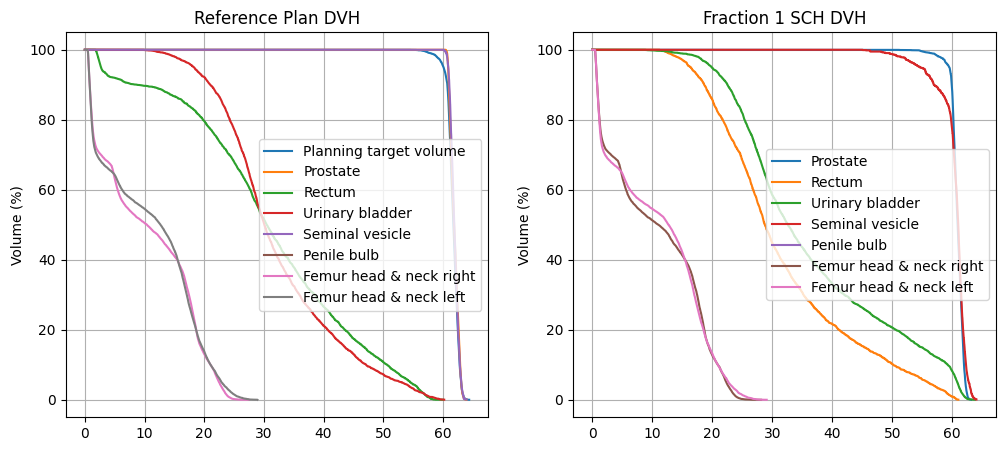

In [7]:
for i in range(1):
  #getting fx 1
  fraction = i

  #file names
  PLANdose_file = str(pt1_path + pt1_sorted[2+fraction*11]['File Name'])
  structure_file = str(pt1_path + pt1_sorted[7+fraction*11]['File Name'])
  REFstructure_file = str(pt1_path + 'REF1')
  REFdose_file = str(pt1_path + 'REF0')

  fig, axs = plt.subplots(1, 2, figsize=(12,5))
  ## plotting
  #plotting scheduled plan
  for structure_id in range(2,11):
      plt.subplot(1, 2, 1)
      plot_dvh(REFstructure_file, REFdose_file, structure_id)
  # Customize the plot
  plt.ylabel('Volume (%)')
  plt.title(f'Reference Plan DVH')
  plt.legend()
  plt.grid(True)
  #plt.plot


  ## plotting
  #plotting scheduled plan
  for structure_id in range(2,11):
      plt.subplot(1, 2, 2)
      plot_dvh(structure_file, PLANdose_file, structure_id)
  # Customize the plot
  plt.ylabel('Volume (%)')
  plt.title(f'Fraction {fraction+1} SCH DVH')
  plt.legend()
  plt.grid(True)
  #plt.plot


### Fraction 1,5,10,15,20

Structure 7 has a volume of 0!


<ipython-input-3-458fbeeb6e9d>:35: RuntimeWarning: invalid value encountered in divide
  volume_percent = (volume_values_cumulative / total_volume) * 100


20221101
Structure 7 has a volume of 0!
20221101
Structure 7 has a volume of 0!
20221107
Structure 7 has a volume of 0!
20221107
Structure 7 has a volume of 0!
20221114
Structure 7 has a volume of 0!
20221114
Structure 7 has a volume of 0!
20221120
Structure 7 has a volume of 0!
20221120
Structure 7 has a volume of 0!
20221129
Structure 7 has a volume of 0!
20221129


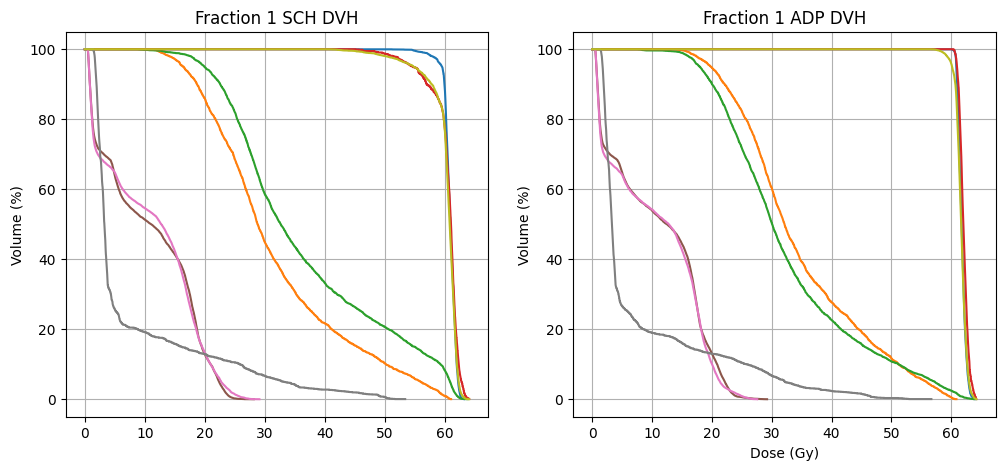

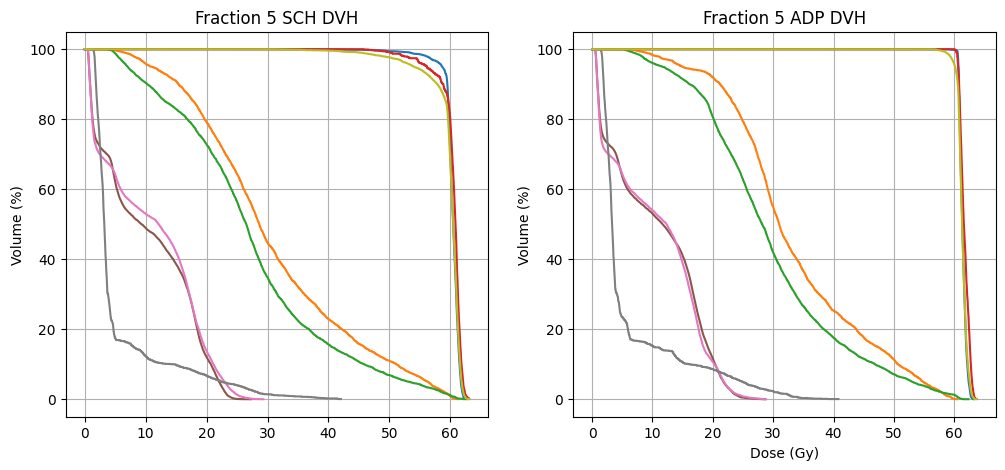

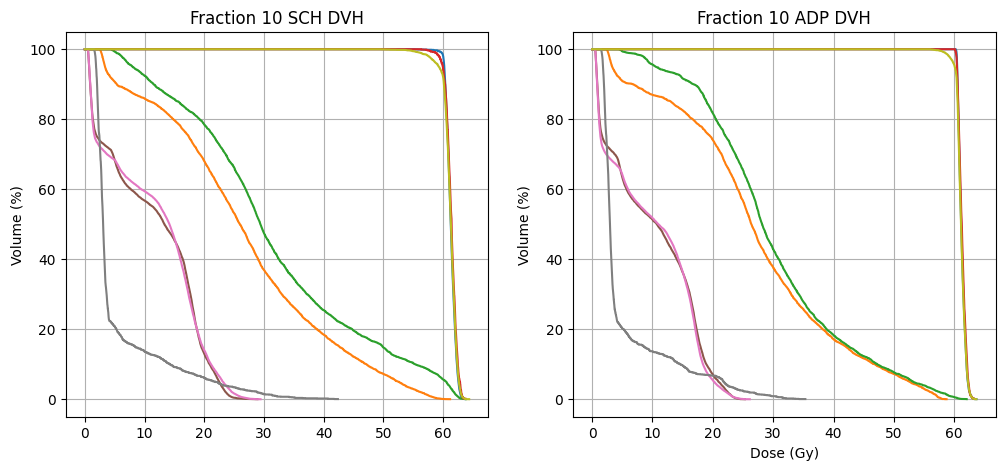

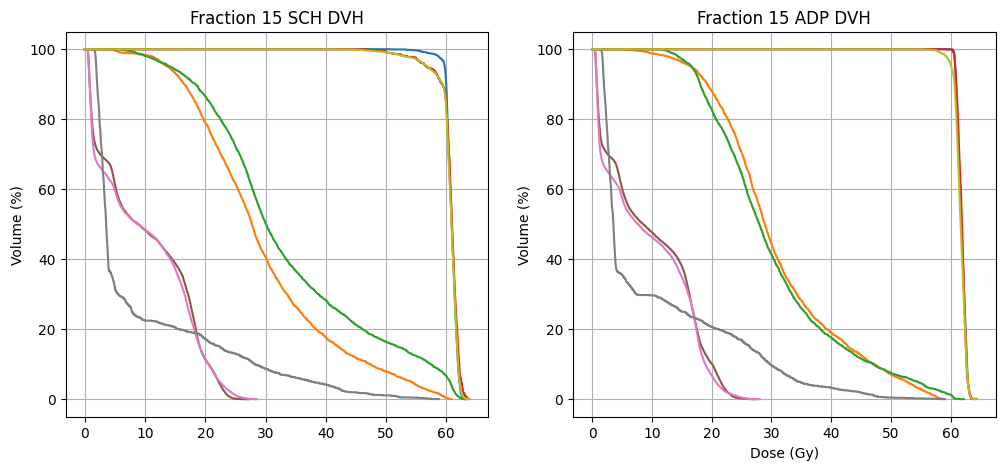

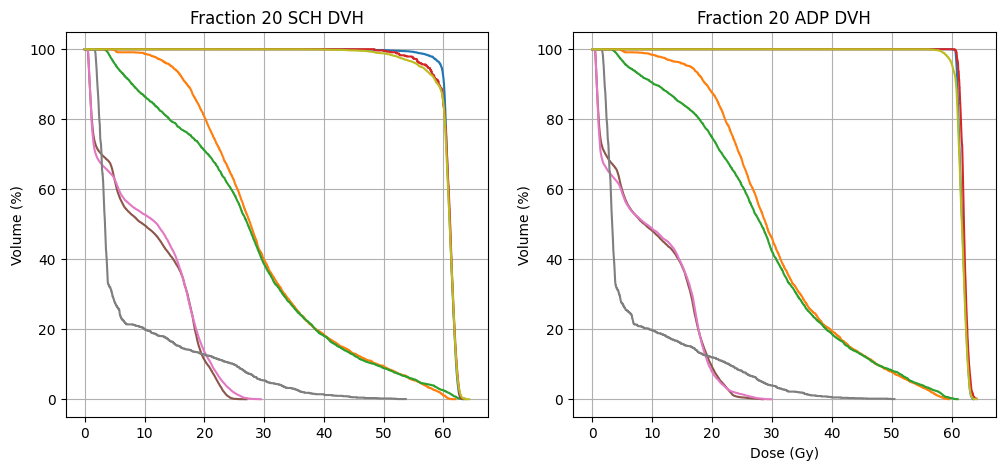

In [ ]:
for i in range(-1,21,5):
  #getting fx 1,5,10,15,20
  if i == -1:
    fraction = 0
  else:
    fraction = i

  #file names
  FRACdose_file = str(pt1_path + pt1_sorted[4+fraction*11]['File Name'])
  PLANdose_file = str(pt1_path + pt1_sorted[2+fraction*11]['File Name'])
  PLAN2dose_file = str(pt1_path + pt1_sorted[3+fraction*11]['File Name'])
  structure_file = str(pt1_path + pt1_sorted[7+fraction*11]['File Name'])
  RECstructure_file = str(pt1_path + pt1_sorted[10+fraction*11]['File Name'])

  fig, axs = plt.subplots(1, 2, figsize=(12,5))
  ## plotting
  #plotting scheduled plan
  for structure_id in range(2,15):
      plt.subplot(1, 2, 1)
      plot_dvh(structure_file, PLANdose_file, structure_id)
  print(pt1_sorted[2+fraction*11]['Date'])
  # Customize the plot
  plt.ylabel('Volume (%)')
  plt.title(f'Fraction {fraction+1} SCH DVH')
  plt.grid(True)

  #plotting adaptive plan
  for structure_id in range(2,15):
      plt.subplot(1, 2, 2)
      plot_dvh(structure_file, PLAN2dose_file, structure_id)
  print(pt1_sorted[3+fraction*11]['Date'])
  # Customize the plot
  plt.xlabel('Dose (Gy)')
  plt.ylabel('Volume (%)')
  plt.title(f'Fraction {fraction+1} ADP DVH')
  plt.grid(True)

## Plotting Structures

In [8]:
fraction = 0
example1 = str(pt1_path + pt1_sorted[6+fraction*11]['File Name'])

In [9]:
#creating dictionary
ds = pydicom.dcmread(example1)
org_dic = {}
for i in (ds.RTROIObservationsSequence):
  org_dic[i.ReferencedROINumber] = i.ROIObservationLabel
org_dic

{'1': 'Body',
 '2': 'Bones',
 '3': 'Prostate',
 '4': 'Rectum',
 '5': 'Bladder',
 '6': 'Seminal vesicle',
 '7': 'Penile bulb',
 '8': 'Femur head & nec',
 '9': 'Femur head & nec',
 '10': 'Bowel',
 '11': 'Sigmoid colon',
 '12': 'PTV60',
 '13': 'Prost+SVfull',
 '14': 'Femurs',
 '15': 'Bowel eval',
 '16': 'Water1',
 '17': 'Couch Exterior',
 '18': 'Couch Interior'}

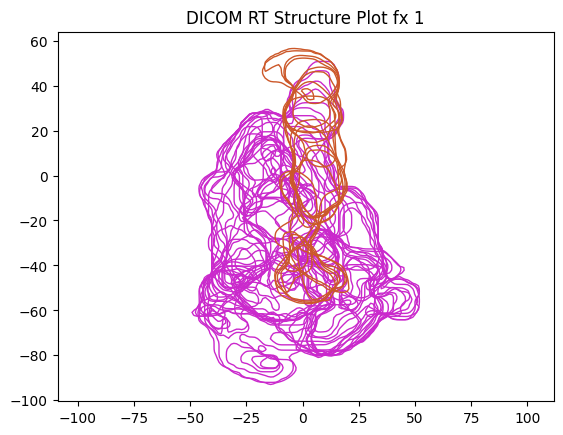

In [11]:
#testing
fraction = 0
for fraction in range(1):
  example1 = str(pt1_path + pt1_sorted[7+fraction*11]['File Name'])
  #plot_rt_structure(example1,12,fraction)
  #plot_rt_structure(example1,4,fraction)
  #plot_rt_structure(example1,5,fraction)
  plot_rt_structure(example1,10,fraction)
  plot_rt_structure(example1,11,fraction)
  plt.show()

## Statistics

### Function

In [85]:
##3-13
def clinical_pt1(rtst, rtdose):
  #find all calcs
  for structure in range(3,13):
    dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
    dvh.rx_dose =  60#Gy
    ## finding all goals
    #PTV
    if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
      PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
      PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
      PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
    #Rectum
    elif dvh.name == 'Rectum':
      RecV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
      RecV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
      RecV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
    #Bladder
    elif dvh.name == 'Bladder':
      BlaV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
      BlaV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
      BlaV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
    #Femur head & neck right
    elif dvh.name == 'Femur head & neck right':
      FRTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
      FRTmax = dvh.max #<5250cGy
    #Femur head & neck left
    elif dvh.name == 'Femur head & neck left':
      FLTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
      FLTmax = dvh.max #<5250cGy
    #Bowel
    elif dvh.name == 'Bowel':
      BowV4650 = dvh.volume_constraint(46, dose_units='Gy').value #2cm3
      Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
    elif dvh.name == 'Sigmoid colon':
      Sigmax = dvh.max #<5500cGy

  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])
  return dose_array

####reference
##3-13
def clinical_pt1REF(rtst, rtdose):
  #find all calcs
  for structure in range(2,13):
    dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
    dvh.rx_dose =  60#Gy
    ## finding all goals
    #PTV
    if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
      PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
      PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
      PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
    #Rectum
    elif dvh.name == 'Rectum':
      RecV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
      RecV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
      RecV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
    #Bladder
    elif dvh.name == 'Bladder':
      BlaV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
      BlaV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
      BlaV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
    #Femur head & neck right
    elif dvh.name == 'Femur head & neck right':
      FRTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
      FRTmax = dvh.max #<5250cGy
    #Femur head & neck left
    elif dvh.name == 'Femur head & neck left':
      FLTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
      FLTmax = dvh.max #<5250cGy
    #Bowel
    elif dvh.name == 'Bowel':
      BowV4650 = dvh.volume_constraint(46, dose_units='Gy').value #2cm3
      Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
    elif dvh.name == 'Sigmoid colon':
      Sigmax = dvh.max #<5500cGy

  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])

  return dose_array


  ########fraction
  ##3-13
def clinical_pt1REAL(rtst, rtdose):
  #find all calcs
  for structure in range(3,13):
    dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
    dvh.rx_dose =  3#Gy
    ## finding all goals
    #PTV
    if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
      PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
      PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
      PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
    #Rectum
    elif dvh.name == 'Rectum':
      RecV65 = 100*(dvh.V108.value/dvh.volume) #<15%
      RecV55 = 100*(dvh.V92.value/dvh.volume) #<25%
      RecV45 = 100*(dvh.V75.value/dvh.volume) #<45%
    #Bladder
    elif dvh.name == 'Bladder':
      BlaV65 = 100*(dvh.V108.value/dvh.volume) #<15%
      BlaV55 = 100*(dvh.V92.value/dvh.volume) #<25%
      BlaV45 = 100*(dvh.V75.value/dvh.volume) #<45%
    #Femur head & neck right
    elif dvh.name == 'Femur head & neck right':
      FRTV50 = 100*(dvh.V83.value/dvh.volume) # #<1%
      FRTmax = dvh.max #<5250cGy
    #Femur head & neck left
    elif dvh.name == 'Femur head & neck left':
      FLTV50 = 100*(dvh.V83.value/dvh.volume) # #<1%
      FLTmax = dvh.max #<5250cGy
    #Bowel
    elif dvh.name == 'Bowel':
      BowV4650 = dvh.V78.value #2cm3
      Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
    elif dvh.name == 'Sigmoid colon':
      Sigmax = dvh.max #<5500cGy

  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])

  return dose_array

### Calcing

In [86]:
##3-12
pt1SCH_goals = np.zeros([16,])
pt1ADP_goals = np.zeros([16,])
pt1REAL_goals = np.zeros([16,])
pt1fraction_SCH = []
pt1fraction_ADP = []
pt1fraction_REAL = []
for fraction in range(20):
  #print(fraction_number)
  #updating file name
  structure_file = str(pt1_path + pt1_sorted[7+fraction*11]['File Name'])
  PLANdose_file = str(pt1_path + pt1_sorted[2+fraction*11]['File Name'])
  PLAN2dose_file = str(pt1_path + pt1_sorted[3+fraction*11]['File Name'])
  REALdose_file = str(pt1_path + pt1_sorted[4+fraction*11]['File Name'])

  #calcing stats
  SCHPLAN = clinical_pt1(structure_file, PLANdose_file)
  ADPPLAN = clinical_pt1(structure_file, PLAN2dose_file)
  #REALPLAN = clinical_pt1REAL(structure_file, REALdose_file)

  #saving stats
  pt1SCH_goals += SCHPLAN
  pt1fraction_SCH.append(SCHPLAN)
  pt1ADP_goals += ADPPLAN
  pt1fraction_ADP.append(ADPPLAN)
  #pt1REAL_goals += REALPLAN
  #pt1fraction_REAL.append(REALPLAN)
  print(fraction)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### Reference File

In [87]:
#files
REFstructure_file = str(pt1_path + 'REF1')
REFdose_file = str(pt1_path + 'REF0')


#### Plotting Reference

In [88]:
ds_ref = pydicom.dcmread(str(pt1_path + 'REF1'))

#creating dictionary
org_dic = {}
for i in (ds_ref.RTROIObservationsSequence):
  org_dic[i.ReferencedROINumber] = i.ROIObservationLabel
org_dic

{'1': 'Body',
 '2': 'PTV60',
 '3': 'Bones',
 '4': 'Prostate',
 '5': 'Rectum',
 '6': 'Bladder',
 '7': 'Seminal vesicle',
 '8': 'Penile bulb',
 '9': 'Femur head & nec',
 '10': 'Femur head & nec',
 '11': 'Bowel',
 '12': 'Sigmoid colon',
 '13': 'Prost+SVfull',
 '14': 'Femurs',
 '15': 'Bowel eval',
 '16': 'Water1',
 '17': 'Couch Exterior',
 '18': 'Couch Interior'}

In [89]:
def edit_bowel_REF(input_file,output_file,bowel_num):
  # Read DICOM file
    ds = pydicom.dcmread(input_file)
    #creating sigmoid
    contour_sequences = ds.ROIContourSequence[bowel_num].ContourSequence
    # Filter out the ContourSequences for the specific structure
    updated_contour_sequences_bowel = [contour_sequences[k] for k in range(len(contour_sequences)) if contour_sequences[k].ContourData[1]<170]
    # Update the original DICOM dataset
    ds.ROIContourSequence[bowel_num].ContourSequence = updated_contour_sequences_bowel
    # Save the modified DICOM file
    ds.save_as(output_file)

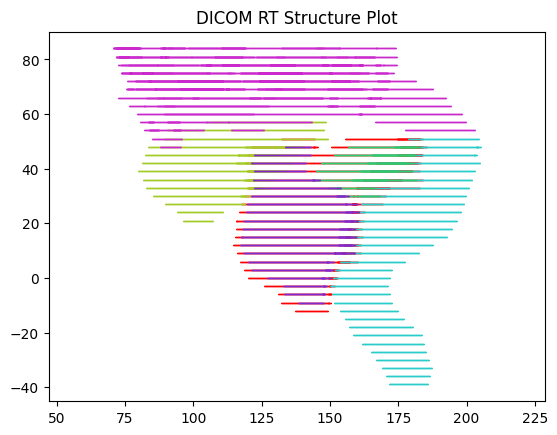

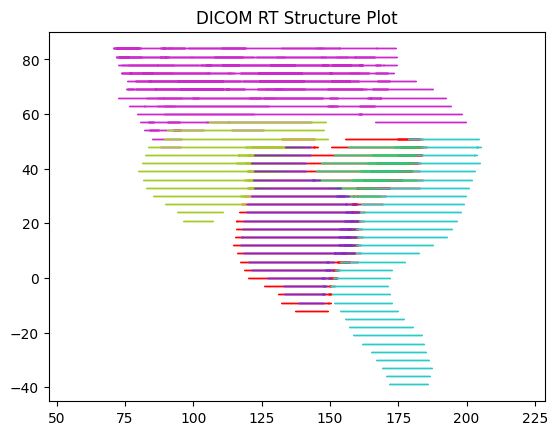

In [93]:
def plot_rt_structure2(file_path,reference_num):
    # Read DICOM RT Structure file
    ds = pydicom.dcmread(file_path)
    # Extract contour data
    contours = ds.ROIContourSequence
    # Plot contours on a 2D plot for the specified organ
    for contour in contours:
        if contour.ReferencedROINumber == reference_num:
            for contour_sequence in contour.ContourSequence:
                contour_data = contour_sequence.ContourData
                num_points = len(contour_data) // 3
                # Extract RGB color information from ROIDisplayColor
                roidisplaycolor = contour.ROIDisplayColor
                color = [float(c) / 255 for c in roidisplaycolor]
                # Extract points from contour data
                points = [(contour_data[i+1], contour_data[i+2]) for i in range(0, len(contour_data)-1, 3)]
                # Plot the contour on a 2D plot with different line styles or markers
                plt.gca().add_patch(Polygon(points, closed=True, fill=None, edgecolor=color))
    plt.axis('equal')
    plt.title(f'DICOM RT Structure Plot')
    #plt.show()

#editing bowel for REF file
REFstructure_file = str(pt1_path + 'REF1')
pt1ref_output = 'pt1ref_v2'
REFstructure_file = str(pt1_path + 'REF1')
edit_bowel_REF(REFstructure_file,pt1ref_output,10)

#plotting original
plot_rt_structure2(REFstructure_file,2)
plot_rt_structure2(REFstructure_file,5)
plot_rt_structure2(REFstructure_file,6)
plot_rt_structure2(REFstructure_file,7)
plot_rt_structure2(REFstructure_file,4)
plot_rt_structure2(REFstructure_file,11)
#plt.show()
#plot_rt_structure2(REFstructure_file,12)
plt.show()

#plotting edited file
plot_rt_structure2(pt1ref_output,2)
plot_rt_structure2(pt1ref_output,11)
#plot_rt_structure2(pt1ref_output,12)
plot_rt_structure2(pt1ref_output,5)
plot_rt_structure2(pt1ref_output,6)
plot_rt_structure2(pt1ref_output,7)
plot_rt_structure2(pt1ref_output,4)

#### Reference Calc

In [94]:
##2-11
#files
REFstructure_file = str(pt1_path + 'REF1')
pt1ref_output = 'pt1ref_v2'
REFdose_file = str(pt1_path + 'REF0')

#solving
pt1REF = clinical_pt1REF(pt1ref_output, REFdose_file)

## Displaying Statistics

In [95]:
#naming arrays
location_names = np.array(['PTVV100','PTVV98','PTVmax',
                  'RectumV65','RectumV55','RectumV45',
                  'BladderV65','BladderV55','BladderV45',
                  'RT FemurV50', 'RT Femur max',
                  'LT FemurV50', 'LT Femur max',
                  'BowelV4650', 'Bowel max',
                  'Sigmoid Colon max'])
goal_names = np.array(['>=95%','>=98%','<=108%',
                       '<=15%','<=25%','<=45%',
                       '<=15%','<=25%','<=45%',
                       '<+1%', '<=5250cGy',
                       '<=1%', '<=5250cGy',
                       '<=2cc', '<=5200cGy',
                       '<=5500cGy'])


#averging stats
def avg_stats(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    #if i != 10 and i != 12 and i != 14 and i != 15:
      new_vals[i] = stats[i] / 20
  return new_vals

#averging stats
def avg_statsREAL(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    if i != 10 and i != 12 and i != 14 and i != 15:
      new_vals[i] = stats[i] / 20
  return new_vals

In [96]:
#calling
pt1SCH = avg_stats(pt1SCH_goals)
pt1ADP = avg_stats(pt1ADP_goals)
pt1REAL = avg_statsREAL(pt1REAL_goals)


#dataframe
df_pt1 = pd.DataFrame({'Pt1 REF': pt1REF,
                       'Pt1 SCH': pt1SCH,
                      'Pt1 ADP': pt1ADP,
                      'Goals': goal_names},
                      location_names)
df_pt1

Pt1 REF     Pt1 SCH     Pt1 ADP      Goals
PTVV100             95.443350   81.137210   95.665555      >=95%
PTVV98              98.311049   90.387653   98.609795      >=98%
PTVmax             107.350000  106.654167  106.815833     <=108%
RectumV65            0.000000    0.000000    0.000000      <=15%
RectumV55            4.410385    4.457031    3.626784      <=25%
RectumV45           17.453863   12.898770   13.990964      <=45%
BladderV65           0.000000    0.000000    0.000000      <=15%
BladderV55           3.243918    8.576983    3.598517      <=25%
BladderV45          13.100437   17.511424   12.130236      <=45%
RT FemurV50          0.000000    0.000000    0.000000       <+1%
RT Femur max        27.510000   27.394000   28.122500  <=5250cGy
LT FemurV50          0.000000    0.000000    0.000000       <=1%
LT Femur max        28.930000   29.123500   28.222500  <=5250cGy
BowelV4650           0.000000    0.112500    0.190312      <=2cc
Bowel max           39.420000   32.776000   37.977000  <=5200cGy
Sigmoid Colon max   51.600000   53.705500   52.415000  <=5500cGy

### Saving dfs as CSV files

In [ ]:
# prompt: do what I did below but what the three fraction lists above
#building df
#pt1fraction_SCH_df = pd.DataFrame(pt1fraction_SCH).transpose()
#pt1fraction_ADP_df = pd.DataFrame(pt1fraction_ADP).transpose()
#pt1fraction_REAL_df = pd.DataFrame(pt1fraction_REAL).transpose()
#pt1_REF_df = pd.DataFrame(pt1REF)#.transpose()

#adding goal names
#pt1fraction_SCH_df.set_index(location_names, inplace=True)
#pt1fraction_ADP_df.set_index(location_names, inplace=True)
#pt1fraction_REAL_df.set_index(location_names, inplace=True)
#pt1_REF_df.set_index(location_names, inplace=True)

#saving dfs as csv files
#df_pt1.to_csv('/content/drive/My Drive/pt1_clinical_stats.csv')
#pt1fraction_SCH_df.to_csv('/content/drive/My Drive/pt1_fractional_stats_SCH.csv')
#pt1fraction_ADP_df.to_csv('/content/drive/My Drive/pt1_fractional_stats_ADP.csv')
#pt1fraction_REAL_df.to_csv('/content/drive/My Drive/pt1_fractional_stats_REAL.csv')
#pt1_REF_df.to_csv('/content/drive/My Drive/pt1_REF_stats.csv')

# Patient 2

In [97]:
pt2_path = '/content/drive/My Drive/DICOMData/Patient2/'

## DIR

In [98]:
#loading in DIR
pt2_DIR = pydicom.dcmread('/content/drive/My Drive/DICOMData/Patient2/DICOMDIR')

In [99]:
#Finding Dose, Structure, REG information
pt2_sorted = DIR_informaiton(file_list(pt2_DIR), pt2_DIR)
print(len(pt2_sorted))

#deleting extra data Fx 6[75], Fx 7[87], Fx 19 [220]
del pt2_sorted[75]
del pt2_sorted[87]
del pt2_sorted[220]
pt2_sorted = {i: pt2_sorted[key] for i, key in enumerate(pt2_sorted)}
print(len(pt2_sorted))

#looking
fraction = 0
dat_list = []
for i in range(fraction*11, fraction*11+11):
  print(i, pt2_sorted[i])

223
220
0 {'File Type': 'REG', 'Date': 20230907, 'Time': '145048.502', 'File Name': 'I11669', 'Delivery Method': 'N/A', 'Plan Type': 'N/A'}
1 {'File Type': 'REG', 'Date': 20230907, 'Time': '150022.797', 'File Name': 'I8397', 'Delivery Method': 'N/A', 'Plan Type': 'N/A'}
2 {'File Type': 'RTDOSE', 'Date': 20230907, 'Time': '144622', 'File Name': 'I8419', 'Delivery Method': 'PLAN', 'Plan Type': 'N/A'}
3 {'File Type': 'RTDOSE', 'Date': 20230907, 'Time': '144714', 'File Name': 'I8417', 'Delivery Method': 'PLAN', 'Plan Type': 'N/A'}
4 {'File Type': 'RTDOSE', 'Date': 20230907, 'Time': '145942', 'File Name': 'I8418', 'Delivery Method': 'FRACTION', 'Plan Type': 'N/A'}
5 {'File Type': 'RTDOSE', 'Date': 20230907, 'Time': '150029', 'File Name': 'I0', 'Delivery Method': 'FRACTION', 'Plan Type': 'N/A'}
6 {'File Type': 'RTSTRUCT', 'Date': 20230907, 'Time': '144553', 'File Name': 'I8479', 'Delivery Method': 'N/A', 'Plan Type': 'SCT/ADP0104'}
7 {'File Type': 'RTSTRUCT', 'Date': 20230907, 'Time': '14455

## DVH

### Reference Plan

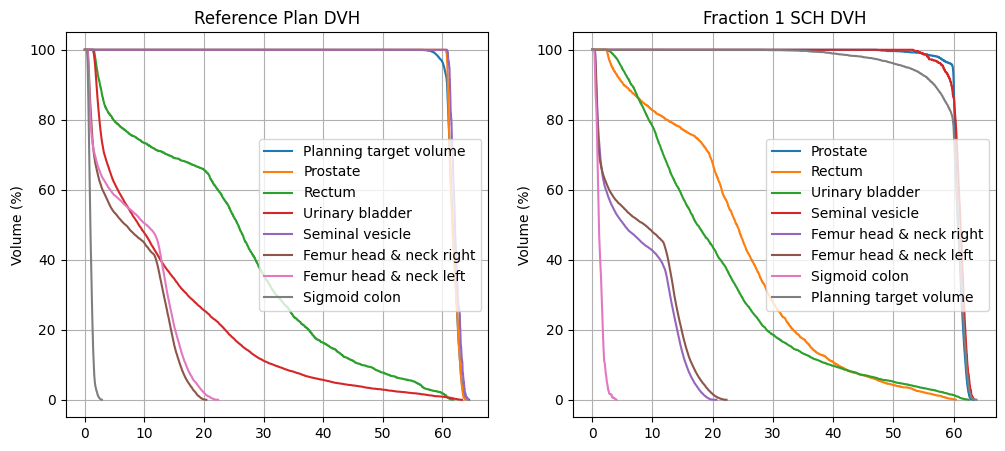

In [40]:
for i in range(1):
  #getting fx 1
  fraction = i

  #file names
  FRACdose_file = str(pt2_path + pt2_sorted[4+fraction*11]['File Name'])
  PLANdose_file = str(pt2_path + pt2_sorted[2+fraction*11]['File Name'])
  PLAN2dose_file = str(pt2_path + pt2_sorted[3+fraction*11]['File Name'])
  structure_file = str(pt2_path + pt2_sorted[7+fraction*11]['File Name'])
  REFstructure_file = str(pt2_path + 'REF1')
  REFdose_file = str(pt2_path + 'REF0')

  fig, axs = plt.subplots(1, 2, figsize=(12,5))
  ## plotting
  #plotting scheduled plan
  for structure_id in range(2,11):
      plt.subplot(1, 2, 1)
      plot_dvh(REFstructure_file, REFdose_file, structure_id)
  # Customize the plot
  plt.ylabel('Volume (%)')
  plt.title(f'Reference Plan DVH')
  plt.legend()
  plt.grid(True)
  #plt.plot


  ## plotting
  #plotting scheduled plan
  for structure_id in range(2,11):
      plt.subplot(1, 2, 2)
      plot_dvh(structure_file, PLANdose_file, structure_id)
  # Customize the plot
  plt.ylabel('Volume (%)')
  plt.title(f'Fraction {fraction+1} SCH DVH')
  plt.legend()
  plt.grid(True)
  #plt.plot


### Comparing REF vs SCH vs ADP vs REC

20230907
20230913
20230922
20230929
20231006


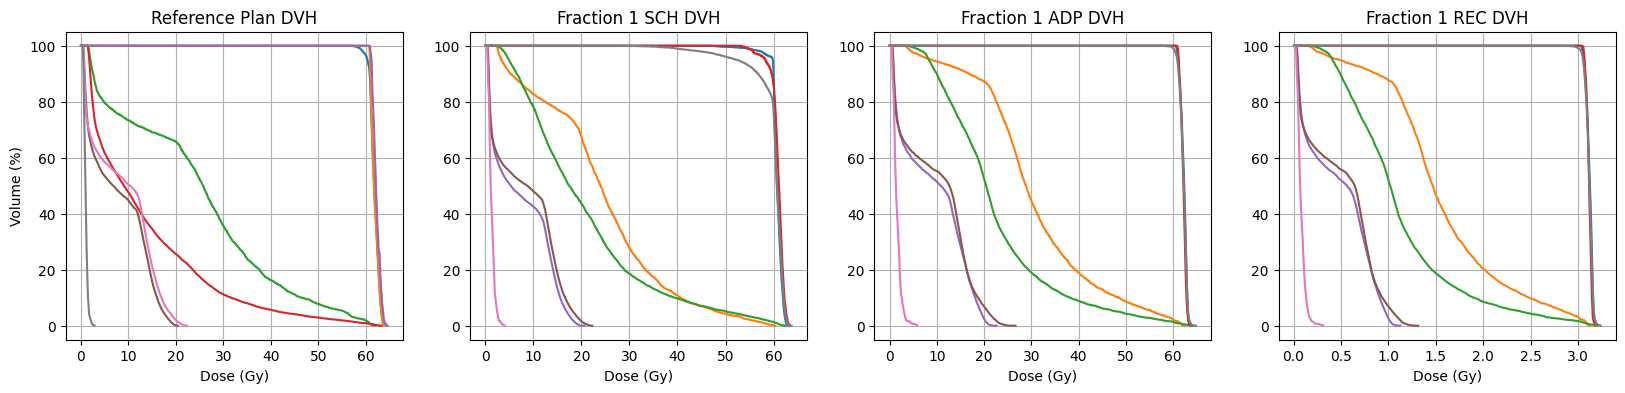

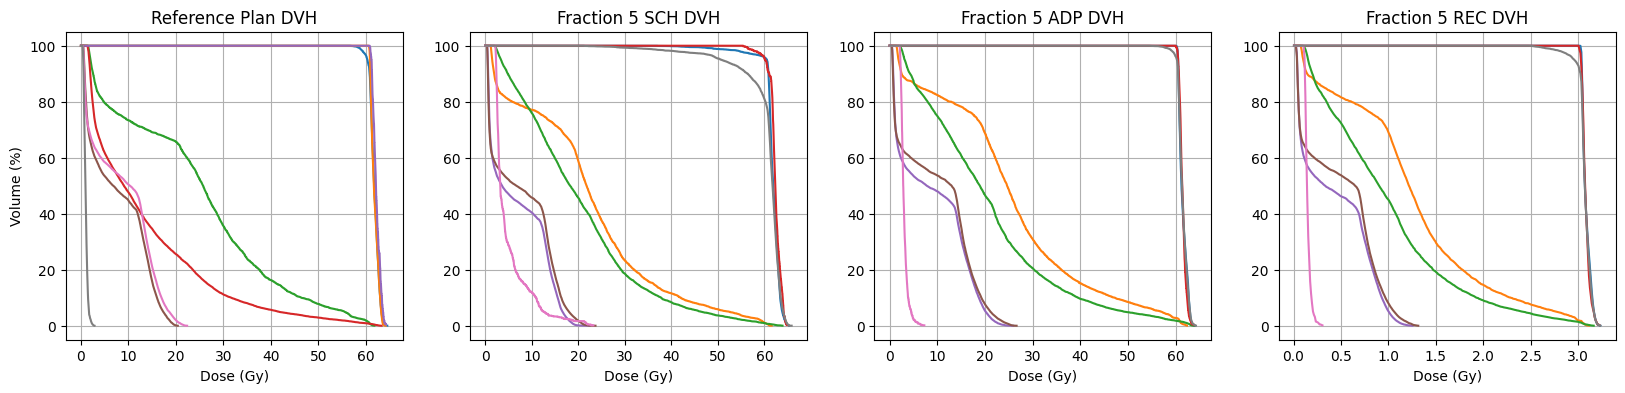

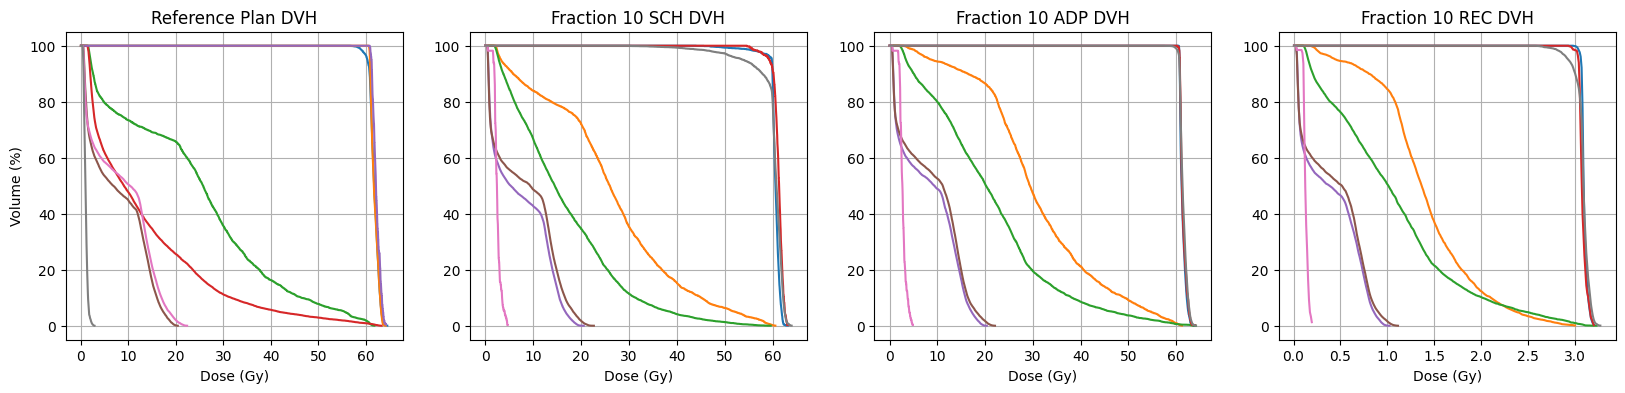

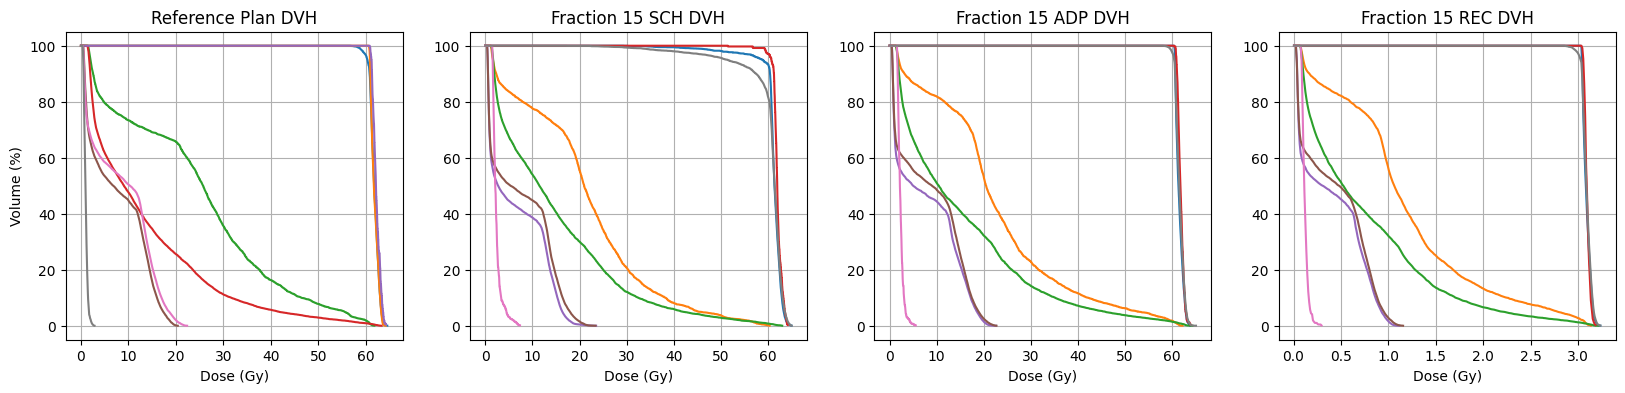

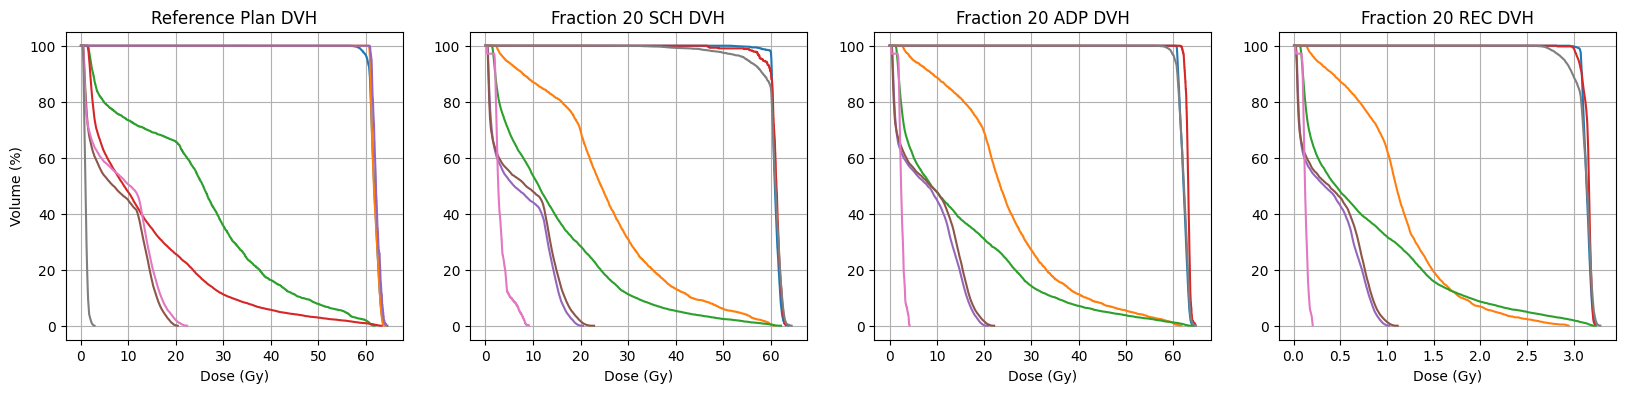

In [ ]:
for i in range(-1,21,5):
  #getting fx 1,5,10,15,20
  if i == -1:
    fraction = 0
  else:
    fraction = i

  #file names
  FRACdose_file = str(pt2_path + pt2_sorted[4+fraction*11]['File Name'])
  PLANdose_file = str(pt2_path + pt2_sorted[2+fraction*11]['File Name'])
  PLAN2dose_file = str(pt2_path + pt2_sorted[3+fraction*11]['File Name'])
  structure_file = str(pt2_path + pt2_sorted[7+fraction*11]['File Name'])
  REFstructure_file = str(pt2_path + 'REF1')
  REFdose_file = str(pt2_path + 'REF0')

  fig, axs = plt.subplots(1, 4, figsize=(20,4))
## plotting
  #plotting scheduled plan
  for structure_id in range(2,11):
      plt.subplot(1, 4, 1)
      plot_dvh(REFstructure_file, REFdose_file, structure_id)
  #print(pydicom.dcmread(REFdose_file).SeriesDate)
  # Customize the plot
  plt.ylabel('Volume (%)')
  plt.xlabel('Dose (Gy)')
  plt.title(f'Reference Plan DVH')
  #plt.legend()
  plt.grid(True)
  #plt.plot

  ## plotting
  #plotting scheduled plan
  for structure_id in range(2,11):
      plt.subplot(1, 4, 2)
      plot_dvh(structure_file, PLANdose_file, structure_id)
  print(pt2_sorted[2+fraction*11]['Date'])
  # Customize the plot
  plt.xlabel('Dose (Gy)')
  plt.title(f'Fraction {fraction+1} SCH DVH')
  plt.grid(True)

  #plotting adaptive plan
  for structure_id in range(2,11):
      plt.subplot(1, 4, 3)
      plot_dvh(structure_file, PLAN2dose_file, structure_id)
  #print(pt2_sorted[3+fraction*11]['Date'])
  # Customize the plot
  plt.xlabel('Dose (Gy)')
  plt.title(f'Fraction {fraction+1} ADP DVH')
  plt.grid(True)

  #plotting adaptive plan
  for structure_id in range(2,11):
      plt.subplot(1, 4, 4)
      plot_dvh(structure_file, FRACdose_file, structure_id)
  #print(pt2_sorted[4+fraction*11]['Date'])
  # Customize the plot
  plt.xlabel('Dose (Gy)')
  plt.title(f'Fraction {fraction+1} REC DVH')
  plt.grid(True)

## Statistics

### Plotting Structures

In [41]:
ds = pydicom.dcmread(str(pt2_path + pt2_sorted[6+fraction*11]['File Name']))

#creating dictionary
org_dic = {}
for i in (ds.RTROIObservationsSequence):
  org_dic[i.ReferencedROINumber] = i.ROIObservationLabel
org_dic

{'1': 'Body',
 '2': 'Prostate',
 '3': 'Rectum',
 '4': 'Bladder',
 '5': 'Seminal vesicle',
 '6': 'Femur head & nec',
 '7': 'Femur head & nec',
 '8': 'Bowel',
 '9': 'Sigmoid colon',
 '10': 'PTV6000',
 '11': 'Prost+SVfull',
 '12': 'Bowel- sigmoid',
 '13': 'Couch Exterior',
 '14': 'Couch Interior'}

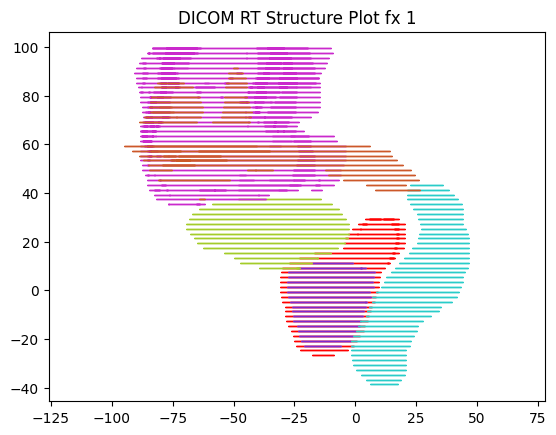

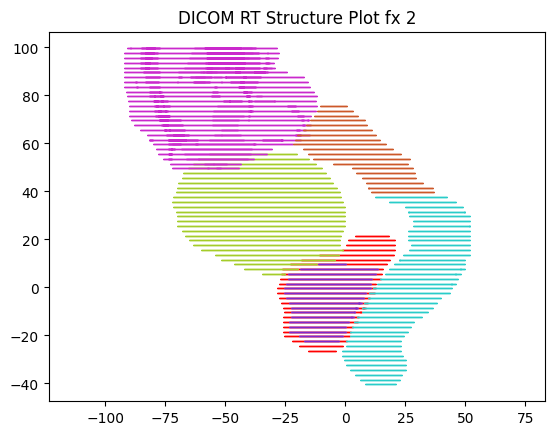

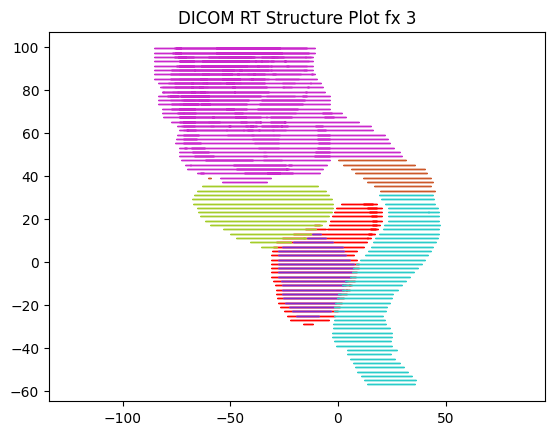

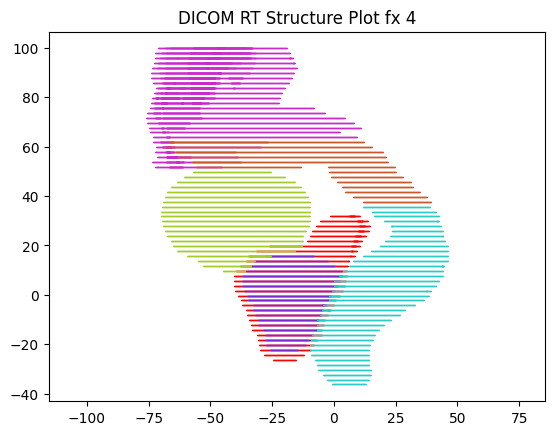

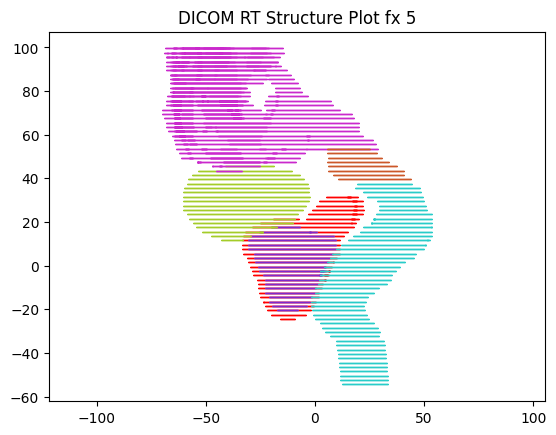

In [42]:
# Example usage with organ_name set to the specific organ you're interested in
fraction = 0
for fraction in range(5):
  pt2structfile = str(pt2_path + pt2_sorted[6+fraction*11]['File Name'])
  plot_rt_structure(pt2structfile,10, fraction)
  plot_rt_structure(pt2structfile,2, fraction)
  plot_rt_structure(pt2structfile,3, fraction)
  plot_rt_structure(pt2structfile,4, fraction)
  plot_rt_structure(pt2structfile,8, fraction)
  plot_rt_structure(pt2structfile,9, fraction)
  plt.show()

### Function

In [100]:
##2-11
def clinical_pt2(rtst, rtdose):
  #find all calcs
  for structure in range(2,11):
    dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
    dvh.rx_dose =  60#Gy
    ## finding all goals
    #PTV
    if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
      PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
      PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
      PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
    #Rectum
    elif dvh.name == 'Rectum':
      RecV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
      RecV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
      RecV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
    #Bladder
    elif dvh.name == 'Bladder':
      BlaV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
      BlaV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
      BlaV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
    #Femur head & neck right
    elif dvh.name == 'Femur head & neck right':
      FRTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
      FRTmax = dvh.max #<5250cGy
    #Femur head & neck left
    elif dvh.name == 'Femur head & neck left':
      FLTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
      FLTmax = dvh.max #<5250cGy
    #Bowel
    elif dvh.name == 'Bowel':
      BowV4650 = dvh.volume_constraint((46.50), dose_units='Gy').value #2cm3
      Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
    elif dvh.name == 'Sigmoid colon':
      Sigmax = dvh.max #<5500cGy

  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])
  return dose_array

  ######fraction
  ##2-11
def clinical_pt2REAL(rtst, rtdose):
  #find all calcs
  for structure in range(2,11):
    dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
    dvh.rx_dose =  3#Gy
    ## finding all goals
    #PTV
    if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
      PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
      PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
      PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
    #Rectum
    elif dvh.name == 'Rectum':
      RecV65 = 100*(dvh.V108.value/dvh.volume) #<15%
      RecV55 = 100*(dvh.V92.value/dvh.volume) #<25%
      RecV45 = 100*(dvh.V75.value/dvh.volume) #<45%
    #Bladder
    elif dvh.name == 'Bladder':
      BlaV65 = 100*(dvh.V108.value/dvh.volume) #<15%
      BlaV55 = 100*(dvh.V92.value/dvh.volume) #<25%
      BlaV45 = 100*(dvh.V75.value/dvh.volume) #<45%
    #Femur head & neck right
    elif dvh.name == 'Femur head & neck right':
      FRTV50 = 100*(dvh.V83.value/dvh.volume) # #<1%
      FRTmax = dvh.max #<5250cGy
    #Femur head & neck left
    elif dvh.name == 'Femur head & neck left':
      FLTV50 = dvh.V83.value # #<1%
      FLTmax = dvh.max #<5250cGy
    #Bowel
    elif dvh.name == 'Bowel':
      BowV4650 = dvh.V78.value #2cc
      Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
    elif dvh.name == 'Sigmoid colon':
      Sigmax = dvh.max #<5500cGy

  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])
  return dose_array



### Calcing

In [101]:
##2-11
pt2SCH_goals = np.zeros([16,])
pt2ADP_goals = np.zeros([16,])
pt2REAL_goals = np.zeros([16,])
pt2fraction_SCH = []
pt2fraction_ADP = []
pt2fraction_REAL = []

for fraction in range(20):
  #print(fraction_number)
  #updating file name
  structure_file = str(pt2_path + pt2_sorted[6+fraction*11]['File Name'])
  PLANdose_file = str(pt2_path + pt2_sorted[2+fraction*11]['File Name'])
  PLAN2dose_file = str(pt2_path + pt2_sorted[3+fraction*11]['File Name'])
  REALdose_file = str(pt2_path + pt2_sorted[4+fraction*11]['File Name'])

  #calcing stats
  SCHPLAN = clinical_pt2(structure_file, PLANdose_file)
  ADPPLAN = clinical_pt2(structure_file, PLAN2dose_file)
  #REALPLAN = clinical_pt2REAL(structure_file, REALdose_file)

  #saving stats
  pt2SCH_goals += SCHPLAN
  pt2fraction_SCH.append(SCHPLAN)
  pt2ADP_goals += ADPPLAN
  pt2fraction_ADP.append(ADPPLAN)
  #pt2REAL_goals += REALPLAN
  #pt2fraction_REAL.append(REALPLAN)
  print(fraction)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


### REF Calc

In [102]:
#REF Files
REFstructure_file = str(pt2_path + 'REF1')
REFdose_file = str(pt2_path + 'REF0')

#calcing stats
pt2REF = clinical_pt2(REFstructure_file, REFdose_file)

## Displaying

In [103]:
#naming arrays
location_names = np.array(['PTVV100','PTVV98','PTVmax',
                  'RectumV65','RectumV55','RectumV45',
                  'BladderV65','BladderV55','BladderV45',
                  'RT FemurV50', 'RT Femur max',
                  'LT FemurV50', 'LT Femur max',
                  'BowelV4650', 'Bowel max',
                  'Sigmoid Colon max'])
goal_names = np.array(['>=95%','>=98%','<=108%',
                       '<=15%','<=25%','<=45%',
                       '<=15%','<=25%','<=45%',
                       '<+1%', '<=52.50Gy',
                       '<=1%', '<=52.50Gy',
                       '<=2cc', '<=52.00Gy',
                       '<=55.00Gy'])


#averging stats
def avg_stats(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    #if i != 10 and i != 12 and i != 14 and i != 15:
        new_vals[i] = stats[i] / 20
  return new_vals

#averging stats
def avg_statsREAL(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    if i != 10 and i != 12 and i != 14 and i != 15:
        new_vals[i] = stats[i] / 18
  return new_vals

In [104]:
##remove nan values at 7 & 17
#newREAL = np.zeros([16,])
#for k in range(20):
 # if k != 7 and k != 17:
  #  newREAL += pt2fraction_REAL[k]

#calling
pt2SCH = avg_stats(pt2SCH_goals)
pt2ADP = avg_stats(pt2ADP_goals)
#pt2REAL = avg_statsREAL(newREAL)

#dataframe
df_pt2 = pd.DataFrame({'Pt2 REF': pt2REF,
                       'Pt2 SCH': pt2SCH,
                      'Pt2 ADP': pt2ADP,
                      'Goals': goal_names},
                      location_names)
df_pt2

Pt2 REF     Pt2 SCH     Pt2 ADP      Goals
PTVV100             96.476633   80.778818   97.754897      >=95%
PTVV98              98.874480   86.171180   99.431492      >=98%
PTVmax             107.483333  107.971667  107.580000     <=108%
RectumV65            0.000000    0.000000    0.000000      <=15%
RectumV55            5.332359    2.731121    5.031089      <=25%
RectumV45           11.139518    7.574835   11.203044      <=45%
BladderV65           0.000000    0.001356    0.000000      <=15%
BladderV55           1.889668    1.875318    2.857532      <=25%
BladderV45           4.104440    4.305452    5.997640      <=45%
RT FemurV50          0.000000    0.000000    0.000000       <+1%
RT Femur max        20.390000   20.991500   21.795000  <=52.50Gy
LT FemurV50          0.000000    0.000000    0.000000       <=1%
LT Femur max        22.350000   22.916000   23.253000  <=52.50Gy
BowelV4650           0.000000    0.000000    0.000000      <=2cc
Bowel max            1.470000    2.154500    2.481000  <=52.00Gy
Sigmoid Colon max    2.860000    9.295500    4.828500  <=55.00Gy

### Saving files as CSVs

In [49]:
# prompt: do what I did below but what the three fraction lists above
#building df
#pt2fraction_SCH_df = pd.DataFrame(pt2fraction_SCH).transpose()
#pt2fraction_ADP_df = pd.DataFrame(pt2fraction_ADP).transpose()
#pt2fraction_REAL_df = pd.DataFrame(pt2fraction_REAL).transpose()
#pt2_REF_df = pd.DataFrame(pt2REF)#.transpose()

#adding goal names
#pt2fraction_SCH_df.set_index(location_names, inplace=True)
#pt2fraction_ADP_df.set_index(location_names, inplace=True)
#pt2fraction_REAL_df.set_index(location_names, inplace=True)
#pt2_REF_df.set_index(location_names, inplace=True)

#saving dfs as csv files
#df_pt2.to_csv('/content/drive/My Drive/pt2_clinical_stats.csv')
#pt2fraction_SCH_df.to_csv('/content/drive/My Drive/pt2_fractional_stats_SCH.csv')
#pt2fraction_ADP_df.to_csv('/content/drive/My Drive/pt2_fractional_stats_ADP.csv')
#pt2fraction_REAL_df.to_csv('/content/drive/My Drive/pt2_fractional_stats_REAL.csv')
#pt2_REF_df.to_csv('/content/drive/My Drive/pt2_REF_stats.csv')

# Patient 3

In [4]:
pt3_path = '/content/drive/My Drive/DICOMData/Patient3/'

## DIR File

In [5]:
#loading in DIR
pt3_DIR = pydicom.dcmread('/content/drive/My Drive/DICOMData/Patient3/DICOMDIR')

In [6]:
#Finding Dose, Structure, REG information
pt3_sorted = DIR_informaiton(file_list(pt3_DIR), pt3_DIR)

#looking
fraction = 0
for i in range(fraction*11, fraction*11+11):
  print(i, pt3_sorted[i])

0 {'File Type': 'REG', 'Date': 20221027, 'Time': '155942.335', 'File Name': 'I12902', 'Delivery Method': 'N/A', 'Plan Type': 'N/A'}
1 {'File Type': 'REG', 'Date': 20221027, 'Time': '161123.511', 'File Name': 'I8341', 'Delivery Method': 'N/A', 'Plan Type': 'N/A'}
2 {'File Type': 'RTDOSE', 'Date': 20221027, 'Time': '155305', 'File Name': 'I8363', 'Delivery Method': 'PLAN', 'Plan Type': 'N/A'}
3 {'File Type': 'RTDOSE', 'Date': 20221027, 'Time': '155453', 'File Name': 'I8361', 'Delivery Method': 'PLAN', 'Plan Type': 'N/A'}
4 {'File Type': 'RTDOSE', 'Date': 20221027, 'Time': '161013', 'File Name': 'I8362', 'Delivery Method': 'FRACTION', 'Plan Type': 'N/A'}
5 {'File Type': 'RTDOSE', 'Date': 20221027, 'Time': '161137', 'File Name': 'I0', 'Delivery Method': 'FRACTION', 'Plan Type': 'N/A'}
6 {'File Type': 'RTSTRUCT', 'Date': 20221027, 'Time': '155219', 'File Name': 'I8421', 'Delivery Method': 'N/A', 'Plan Type': 'SCT/ADP0103'}
7 {'File Type': 'RTSTRUCT', 'Date': 20221027, 'Time': '155219', 'Fil

## DVHs

### Fraction 1,5,10,15,20

20221027
20221027
20221102
20221102
20221109
20221109
20221116
20221116
20221123
20221123


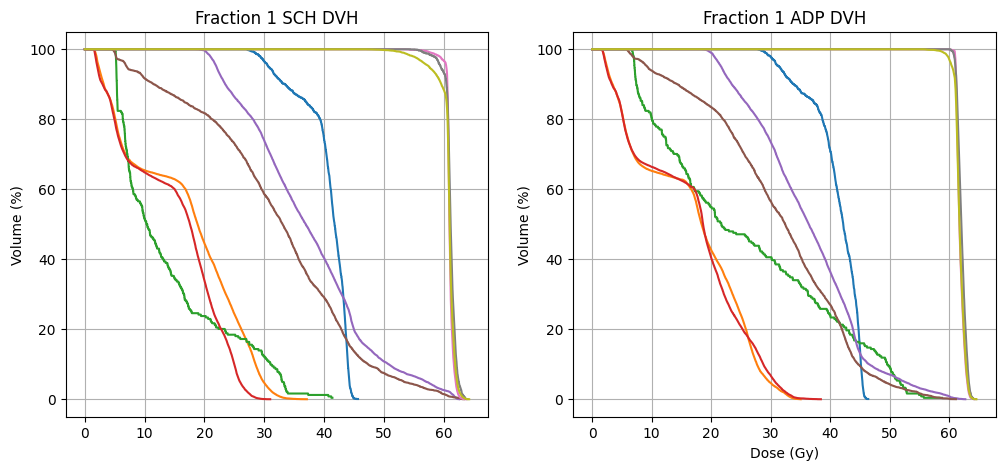

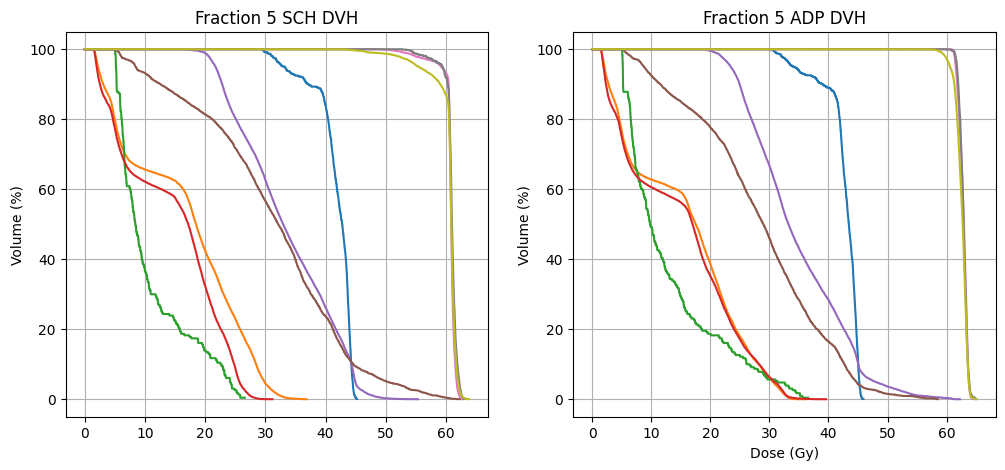

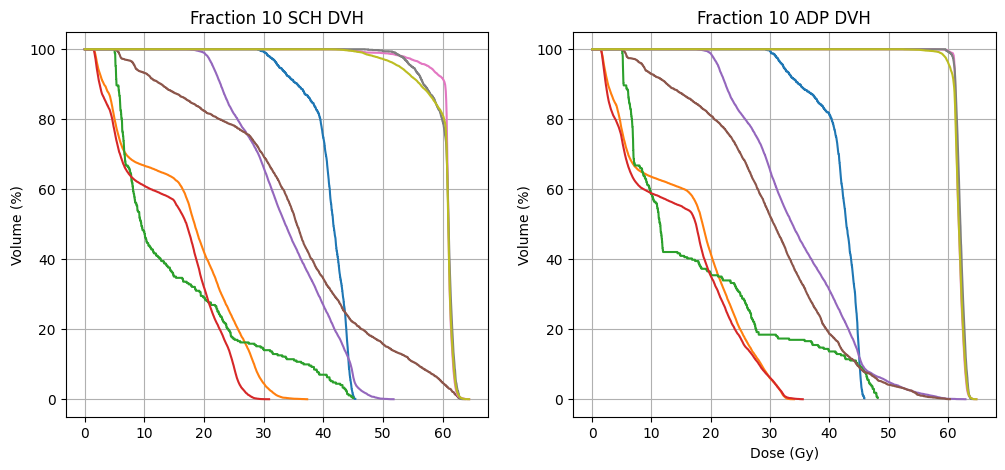

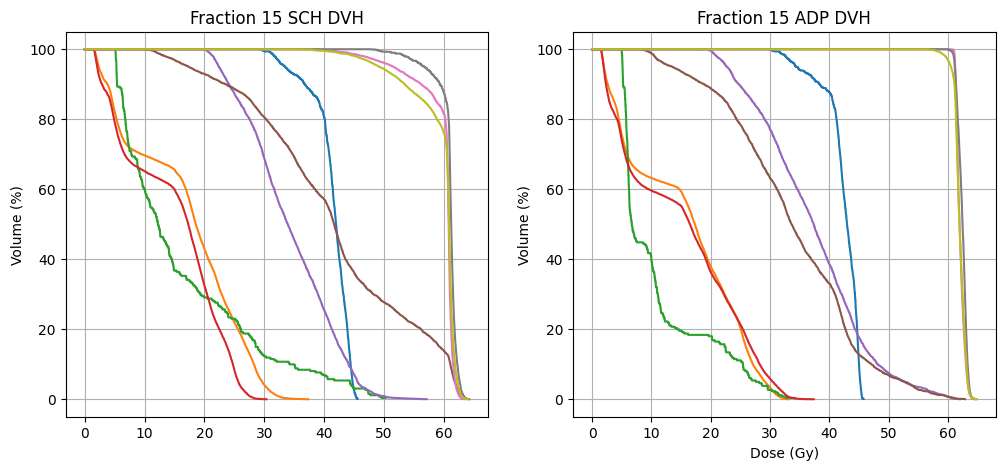

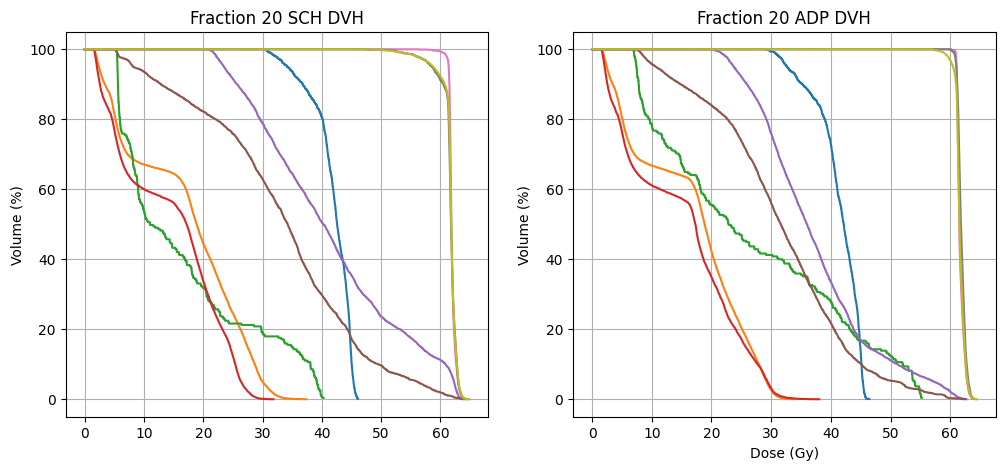

In [57]:
for i in range(-1,21,5):
  #getting fx 1,5,10,15,20
  if i == -1:
    fraction = 0
  else:
    fraction = i

  #file names
  FRACdose_file = str(pt3_path + pt3_sorted[4+fraction*11]['File Name'])
  PLANdose_file = str(pt3_path + pt3_sorted[2+fraction*11]['File Name'])
  PLAN2dose_file = str(pt3_path + pt3_sorted[3+fraction*11]['File Name'])
  structure_file = str(pt3_path + pt3_sorted[7+fraction*11]['File Name'])
  RECstructure_file = str(pt3_path + pt3_sorted[10+fraction*11]['File Name'])

  fig, axs = plt.subplots(1, 2, figsize=(12,5))
  ## plotting
  #plotting scheduled plan
  for structure_id in range(2,14):
    if structure_id != 3:
      plt.subplot(1, 2, 1)
      plot_dvh(structure_file, PLANdose_file, structure_id)
  print(pt3_sorted[2+fraction*11]['Date'])
  # Customize the plot
  plt.ylabel('Volume (%)')
  plt.title(f'Fraction {fraction+1} SCH DVH')
  plt.grid(True)

  #plotting adaptive plan
  for structure_id in range(2,14):
    if structure_id != 3:
      plt.subplot(1, 2, 2)
      plot_dvh(structure_file, PLAN2dose_file, structure_id)
  print(pt3_sorted[3+fraction*11]['Date'])
  # Customize the plot
  plt.xlabel('Dose (Gy)')
  plt.ylabel('Volume (%)')
  plt.title(f'Fraction {fraction+1} ADP DVH')
  plt.grid(True)

### Plotting Structures

In [7]:
fraction = 0
example = str(pt3_path + pt3_sorted[6+fraction*11]['File Name'])
ds = pydicom.dcmread(example)

In [8]:
#creating dictionary
org_dic = {}
for i in (ds.RTROIObservationsSequence):
  org_dic[i.ReferencedROINumber] = i.ROIObservationLabel
org_dic

{'1': 'Body',
 '2': 'Sigmoid colon',
 '3': 'Bowel',
 '4': 'Femur head & nec',
 '5': 'Penile bulb',
 '6': 'Femur head & nec',
 '7': 'Bladder',
 '8': 'Rectum',
 '9': 'Prostate',
 '10': 'Bones',
 '11': 'Seminal vesicle',
 '12': 'CTV4400',
 '13': 'PTV6000',
 '14': 'PTV4400',
 '15': 'Bowel Eval',
 '16': '44 alone',
 '17': 'Prost+SVfull',
 '18': 'Stainless_Steel1',
 '19': 'Titanium1',
 '20': 'Water1',
 '21': 'Couch Exterior',
 '22': 'Couch Interior'}

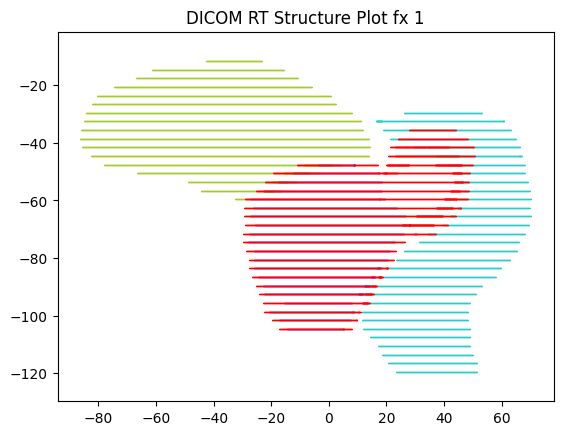

In [10]:
#plotting
plot_rt_structure(example,7, fraction)
plot_rt_structure(example,8, fraction)
plot_rt_structure(example,9, fraction)
plot_rt_structure(example,13, fraction)

### Modifying DICOM

In [12]:
def modify_dicom_rt_structure(input_file, output_file):
    # Read DICOM file
    ds = pydicom.dcmread(input_file)
    # Access the ContourSequence
    contour_sequences = ds.ROIContourSequence[2].ContourSequence
    # Filter out the ContourSequences for the specific structure
    updated_contour_sequences = [contour for contour in contour_sequences if len(contour.ContourData) < 50000]
    # Update the original DICOM dataset
    ds.ROIContourSequence[2].ContourSequence = updated_contour_sequences
    # Save the modified DICOM file
    ds.save_as(output_file)

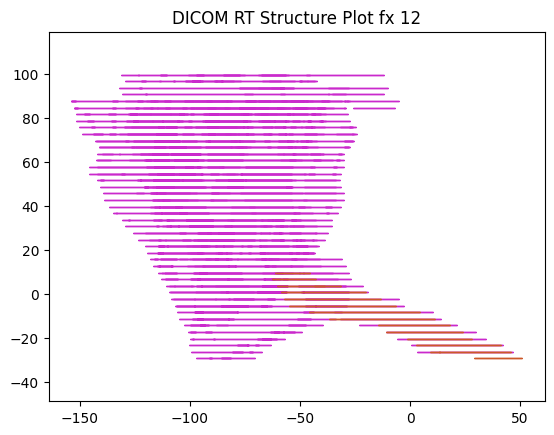

In [16]:
# Example usage
input_file_path = 'path/to/your/input_file.dcm'
output_file_path = '/content/output_file.dcm'

#changing DICOm file to work
#modify_dicom_rt_structure(example, output_file_path)
fraction = 11
structure_file = str(pt3_path + pt3_sorted[7+fraction*11]['File Name'])
modify_dicom_rt_structure(structure_file, output_file_path)

# Example usage with file_path set to the path of your DICOM RT Structure file
plot_rt_structure('/content/output_file.dcm',3,fraction)
plot_rt_structure('/content/output_file.dcm',2,fraction)

## Statistics

### Function

In [17]:
##2-14
def clinical_pt3(rtst, rtdose):
  #find all calcs
  for structure in range(2,14):
    #if structure != 3:
    dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
    dvh.rx_dose =  60#Gy
    #print('dose 60Gy')
      ## finding all goals
      #PTV
    if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
      PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
      PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
      PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
    #Rectum
    elif dvh.name == 'Rectum':
      RecV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
      RecV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
      RecV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
    #Bladder
    elif dvh.name == 'Bladder':
      BlaV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
      BlaV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
      BlaV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
    #Femur head & neck right
    elif dvh.name == 'Femur head & neck right':
      FRTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
      FRTmax = dvh.max #<5250cGy
    #Femur head & neck left
    elif dvh.name == 'Femur head & neck left':
      FLTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
      FLTmax = dvh.max #<5250cGy
    #Bowel
    elif dvh.name == 'Bowel':
      BowV4650 = 100*(dvh.volume_constraint(46, dose_units='Gy').value / dvh.volume) #2cm3
      Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
    elif dvh.name == 'Sigmoid colon':
      Sigmax = dvh.max #<5500cGy
  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])
  return dose_array

####reference
##2-14
def clinical_pt3REF(rtst, rtdose):
  #find all calcs
  for structure in range(2,13):
    #if structure != 3:
    dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
    dvh.rx_dose =  60#Gy
    #print('dose 60Gy')
      ## finding all goals
      #PTV
    if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
      PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
      PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
      PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
    #Rectum
    elif dvh.name == 'Rectum':
      RecV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
      RecV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
      RecV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
    #Bladder
    elif dvh.name == 'Bladder':
      BlaV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
      BlaV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
      BlaV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
    #Femur head & neck right
    elif dvh.name == 'Femur head & neck right':
      FRTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
      FRTmax = dvh.max #<5250cGy
    #Femur head & neck left
    elif dvh.name == 'Femur head & neck left':
      FLTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
      FLTmax = dvh.max #<5250cGy
    #Bowel
    elif dvh.name == 'Bowel':
      BowV4650 = dvh.volume_constraint((46.50), dose_units='cGy').value #2cm3
      Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
    elif dvh.name == 'Sigmoid colon':
      Sigmax = dvh.max #<5500cGy
  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])
  return dose_array

##3-13
def clinical_pt3REAL(rtst, rtdose):
  #find all calcs
  for structure in range(4,14):
    #if structure != 3:
    dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
    dvh.rx_dose =  3#Gy
    #print('dose 3Gy')
      ## finding all goals
      #PTV
    if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
      #print('ptv')
      PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
      PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
      PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
    #Rectum
    elif dvh.name == 'Rectum':
      #print('rec')
      RecV65 = 100*(dvh.V108.value/dvh.volume) #<15%
      RecV55 = 100*(dvh.V92.value/dvh.volume) #<25%
      RecV45 = 100*(dvh.V75.value/dvh.volume) #<45%
    #Bladder
    elif dvh.name == 'Bladder':
      #print('blad')
      BlaV65 = 100*(dvh.V108.value/dvh.volume) #<15%
      BlaV55 = 100*(dvh.V92.value/dvh.volume) #<25%
      BlaV45 = 100*(dvh.V75.value/dvh.volume) #<45%
    #Femur head & neck right
    elif dvh.name == 'Femur head & neck right':
      #print('rt fe')
      FRTV50 = 100*(dvh.V83.value/dvh.volume) # #<1%
      FRTmax = dvh.max #<5250cGy
    #Femur head & neck left
    elif dvh.name == 'Femur head & neck left':
      #print('lt fe')
      FLTV50 = 100*(dvh.V83.value/dvh.volume) # #<1%
      FLTmax = dvh.max #<5250cGy
    #Bowel
    #elif dvh.name == 'Bowel':
    #  print('bow')
    #  BowV4650 = dvh.V78.value #2cm3
     # Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
    #elif dvh.name == 'Sigmoid colon':
      #print('sig')
      #Sigmax = dvh.max #<5500cGy
  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,])
                   #BowV4650, Bowmax,
                   #Sigmax])

  return dose_array

#averging stats
def avg_stats(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    #if i != 10 and i != 12:# and i != 14 and i != 15:
      new_vals[i] = stats[i] / 20
  return new_vals

#averging stats
def avg_statsREAL(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    if i != 10 and i != 12:# and i != 14 and i != 15:
      new_vals[i] = stats[i] / 20
  return new_vals

### Calcing

In [20]:
##0-4,7,8,9
##4-14
pt3SCH_goals = np.zeros([16,])
pt3ADP_goals = np.zeros([16,])
#pt3REAL_goals = np.zeros([16,])
pt3fraction_SCH = []
pt3fraction_ADP = []
#pt3fraction_REAL = []
for fraction in range(20):
  #updating file name
  structure_file = str(pt3_path + pt3_sorted[7+fraction*11]['File Name'])
  PLANdose_file = str(pt3_path + pt3_sorted[2+fraction*11]['File Name'])
  PLAN2dose_file = str(pt3_path + pt3_sorted[3+fraction*11]['File Name'])
  #FRACdose_file = str(pt3_path + pt3_sorted[4+fraction*11]['File Name'])

  #moidfying structure file
  new_structure_file = '/content/output_file.dcm'
  modify_dicom_rt_structure(structure_file, new_structure_file)

  #calcing stats
  print(f'fraction {fraction}')
  SCHPLAN = clinical_pt3(new_structure_file, PLANdose_file)
  ADPPLAN = clinical_pt3(new_structure_file, PLAN2dose_file)
  #REALPLAN = clinical_pt3REAL(structure_file, FRACdose_file)

  #saving stats
  pt3SCH_goals += SCHPLAN
  pt3fraction_SCH.append(SCHPLAN)
  pt3ADP_goals += ADPPLAN
  pt3fraction_ADP.append(ADPPLAN)
  #pt3REAL_goals += REALPLAN
  #pt3fraction_REAL.append(REALPLAN)
  print('------')

fraction 0
------
fraction 1
------
fraction 2
------
fraction 3
------
fraction 4
------
fraction 5
------
fraction 6
------
fraction 7
------
fraction 8
------
fraction 9
------
fraction 10
------
fraction 11
------
fraction 12
------
fraction 13
------
fraction 14
------
fraction 15
------
fraction 16
------
fraction 17
------
fraction 18
------
fraction 19
------


### Reference Calc

In [21]:
##2-11
#files
REFstructure_file = str(pt3_path + 'REF1')
REFdose_file = str(pt3_path + 'REF0')

#solving
pt3REF = clinical_pt3REF(REFstructure_file, REFdose_file)

In [22]:
pt3REF

array([ 96.4385801 ,  98.80896777, 108.06666667,   0.        ,
         2.78724063,  10.68442242,   0.        ,   3.99514608,
        18.9769439 ,   0.        ,  36.02      ,   0.        ,
        31.9       ,   0.        ,  46.17      ,  46.17      ])

## Displaying Data

In [23]:
#naming arrays
location_names = np.array(['PTVV100','PTVV98','PTVmax',
                  'RectumV65','RectumV55','RectumV45',
                  'BladderV65','BladderV55','BladderV45',
                  'RT FemurV50', 'RT Femur max',
                  'LT FemurV50', 'LT Femur max',
                  'BowelV4650', 'Bowel max',
                  'Sigmoid Colon max'])
goal_names = np.array(['>=95%','>=98%','<=108%',
                       '<=15%','<=25%','<=45%',
                       '<=15%','<=25%','<=45%',
                       '<+1%', '<=52.50Gy',
                       '<=1%', '<=52.50Gy',
                       '<=2cc', '<=5200cGy',
                       '<=5500cGy'])

#averging stats
def avg_stats(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    #if i != 10 and i != 12 and i != 14 and i != 15:
        new_vals[i] = stats[i] / 20
  return new_vals

In [24]:
#getting averages
pt3SCH = avg_stats(pt3SCH_goals)
pt3ADP = avg_stats(pt3ADP_goals)
#pt3REAL = avg_statsREAL(pt3REAL_goals)

#dataframe
df_pt3 = pd.DataFrame({'Pt3 REF': pt3REF,
                       'Pt3 SCH': pt3SCH,
                      'Pt3 ADP': pt3ADP,
                      'Goals': goal_names},
                      location_names)
df_pt3

Pt3 REF     Pt3 SCH     Pt3 ADP      Goals
PTVV100             96.438580   86.239015   96.759178      >=95%
PTVV98              98.808968   89.752384   99.084197      >=98%
PTVmax             108.066667  107.351667  108.285000     <=108%
RectumV65            0.000000    0.000000    0.000000      <=15%
RectumV55            2.787241    7.250850    2.006343      <=25%
RectumV45           10.684422   17.300600    9.794090      <=45%
BladderV65           0.000000    0.000000    0.000000      <=15%
BladderV55           3.995146    3.389705    3.305348      <=25%
BladderV45          18.976944   15.775083   15.772218      <=45%
RT FemurV50          0.000000    0.000000    0.000000       <+1%
RT Femur max        36.020000   37.055500   34.575000  <=52.50Gy
LT FemurV50          0.000000    0.000000    0.000000       <=1%
LT Femur max        31.900000   30.981500   36.623500  <=52.50Gy
BowelV4650           0.000000    0.237595    0.026931      <=2cc
Bowel max           46.170000   47.798500   47.202500  <=5200cGy
Sigmoid Colon max   46.170000   45.592000   46.044500  <=5500cGy

## CSV Files

In [ ]:
# prompt: do what I did below but what the three fraction lists above
#building df
#pt3fraction_SCH_df = pd.DataFrame(pt3fraction_SCH).transpose()
#pt3fraction_ADP_df = pd.DataFrame(pt3fraction_ADP).transpose()
#pt3fraction_REAL_df = pd.DataFrame(pt3fraction_REAL).transpose()
#pt3_REF_df = pd.DataFrame(pt3REF)#.transpose()

#adding goal names
#pt3fraction_SCH_df.set_index(location_names, inplace=True)
#pt3fraction_ADP_df.set_index(location_names, inplace=True)
#pt3fraction_REAL_df.set_index(location_names, inplace=True)
#pt3_REF_df.set_index(location_names, inplace=True)

#saving dfs as csv files
#df_pt3.to_csv('/content/drive/My Drive/pt3_clinical_stats.csv')
#pt3fraction_SCH_df.to_csv('/content/drive/My Drive/pt3_fractional_stats_SCH.csv')
#pt3fraction_ADP_df.to_csv('/content/drive/My Drive/pt3_fractional_stats_ADP.csv')
#pt3fraction_REAL_df.to_csv('/content/drive/My Drive/pt3_fractional_stats_REAL.csv')
#pt3_REF_df.to_csv('/content/drive/My Drive/pt3_REF_stats.csv')

# Patient 4

In [25]:
pt4_path = '/content/drive/My Drive/DICOMData/Patient4/'

## DIR

In [26]:
#loading in DIR
pt4_DIR = pydicom.dcmread('/content/drive/My Drive/DICOMData/Patient4/DICOMDIR')

In [27]:
#Finding Dose, Structure, REG information
pt4_sorted = DIR_informaiton(file_list(pt4_DIR), pt4_DIR)

#looking
fraction = 0
for i in range(fraction*11, fraction*11+11):
  print(i, pt4_sorted[i])

0 {'File Type': 'REG', 'Date': 20221012, 'Time': '131642.267', 'File Name': 'I13315', 'Delivery Method': 'N/A', 'Plan Type': 'N/A'}
1 {'File Type': 'REG', 'Date': 20221012, 'Time': '132644.709', 'File Name': 'I8339', 'Delivery Method': 'N/A', 'Plan Type': 'N/A'}
2 {'File Type': 'RTDOSE', 'Date': 20221012, 'Time': '131051', 'File Name': 'I8360', 'Delivery Method': 'PLAN', 'Plan Type': 'N/A'}
3 {'File Type': 'RTDOSE', 'Date': 20221012, 'Time': '131223', 'File Name': 'I8359', 'Delivery Method': 'PLAN', 'Plan Type': 'N/A'}
4 {'File Type': 'RTDOSE', 'Date': 20221012, 'Time': '132539', 'File Name': 'I8361', 'Delivery Method': 'FRACTION', 'Plan Type': 'N/A'}
5 {'File Type': 'RTDOSE', 'Date': 20221012, 'Time': '132656', 'File Name': 'I0', 'Delivery Method': 'FRACTION', 'Plan Type': 'N/A'}
6 {'File Type': 'RTSTRUCT', 'Date': 20221012, 'Time': '131014', 'File Name': 'I8419', 'Delivery Method': 'N/A', 'Plan Type': 'SCT/ADP0101'}
7 {'File Type': 'RTSTRUCT', 'Date': 20221012, 'Time': '131014', 'Fil

## DVH

## Fraction 1,5,10,15,20

20221012
20221012
20221018
20221018
20221026
20221026
20221107
20221107
20221114
20221114


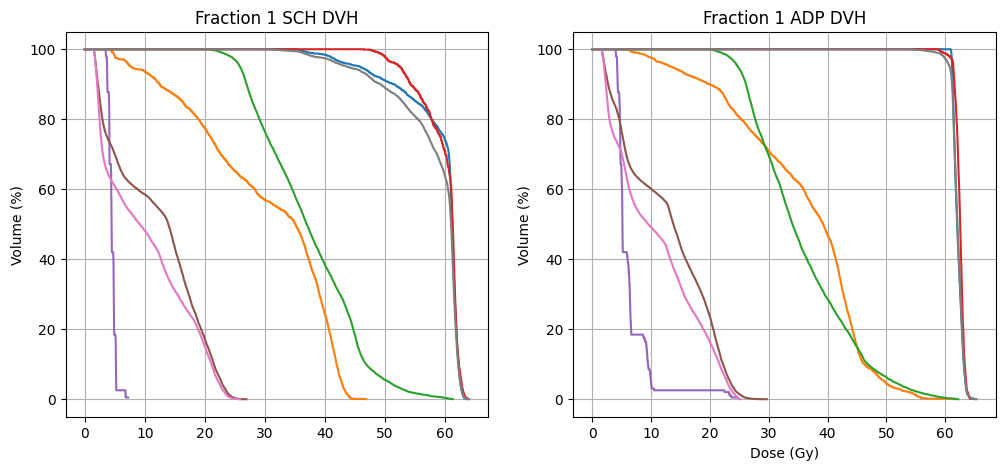

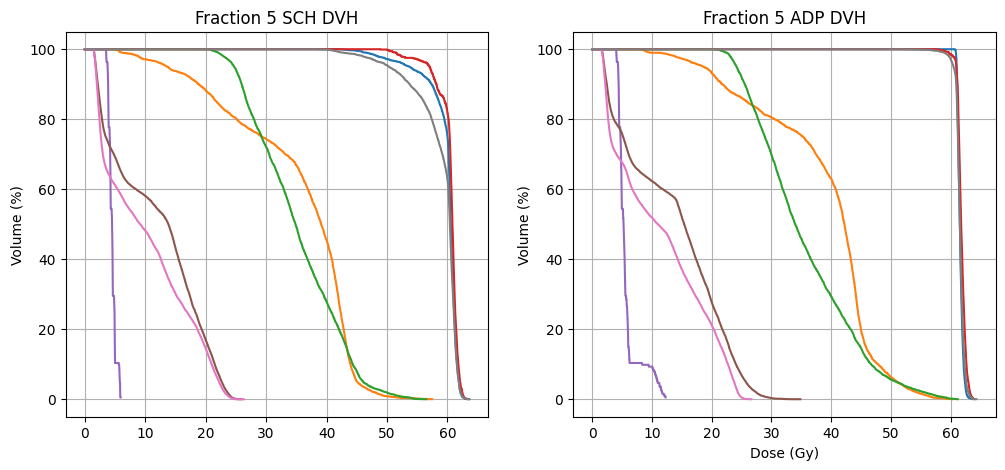

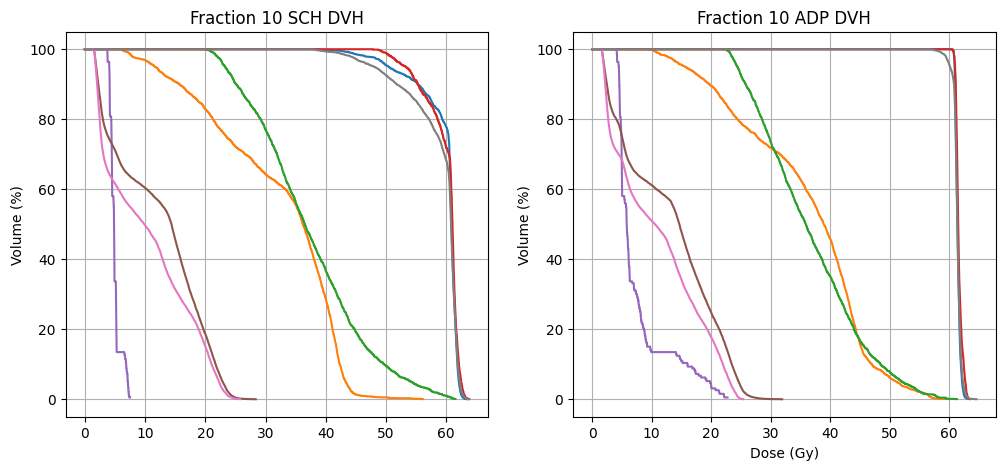

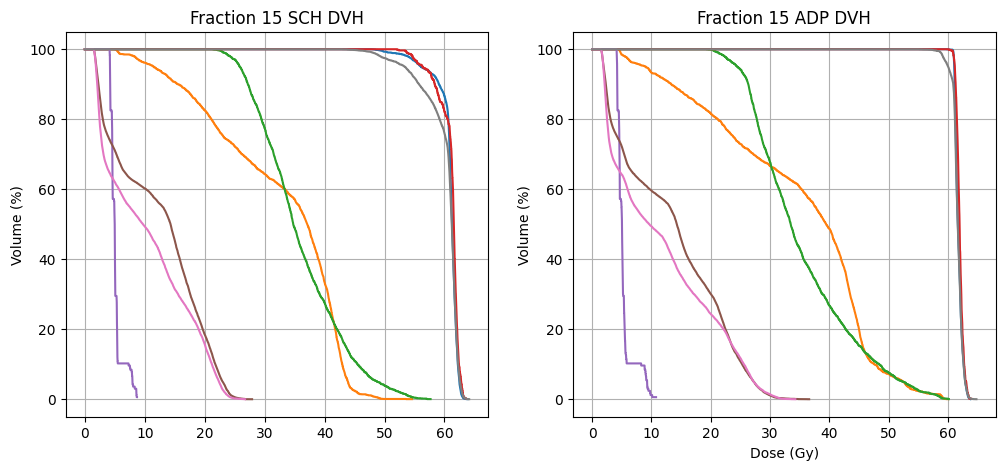

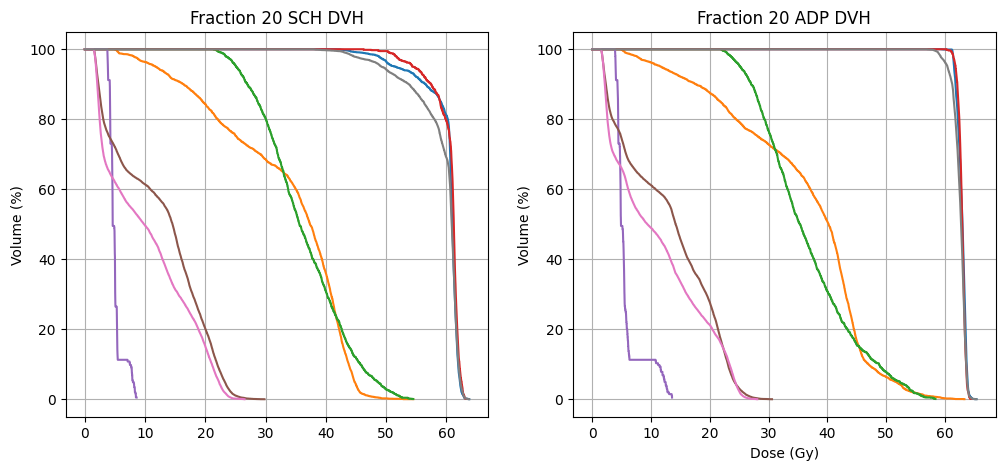

In [ ]:
for i in range(-1,21,5):
  #getting fx 1,5,10,15,20
  if i == -1:
    fraction = 0
  else:
    fraction = i

  #file names
  FRACdose_file = str(pt4_path + pt4_sorted[4+fraction*11]['File Name'])
  PLANdose_file = str(pt4_path + pt4_sorted[2+fraction*11]['File Name'])
  PLAN2dose_file = str(pt4_path + pt4_sorted[3+fraction*11]['File Name'])
  structure_file = str(pt4_path + pt4_sorted[7+fraction*11]['File Name'])
  RECstructure_file = str(pt4_path + pt4_sorted[10+fraction*11]['File Name'])

  fig, axs = plt.subplots(1, 2, figsize=(12,5))
  ## plotting
  #plotting scheduled plan
  for structure_id in range(3,13):
    if structure_id != 10:
      plt.subplot(1, 2, 1)
      plot_dvh(structure_file, PLANdose_file, structure_id)
  print(pt4_sorted[2+fraction*11]['Date'])
  # Customize the plot
  plt.ylabel('Volume (%)')
  plt.title(f'Fraction {fraction+1} SCH DVH')
  plt.grid(True)

  #plotting adaptive plan
  for structure_id in range(3,13):
    if structure_id != 10:
      plt.subplot(1, 2, 2)
      plot_dvh(structure_file, PLAN2dose_file, structure_id)
  print(pt4_sorted[3+fraction*11]['Date'])
  # Customize the plot
  plt.xlabel('Dose (Gy)')
  plt.ylabel('Volume (%)')
  plt.title(f'Fraction {fraction+1} ADP DVH')
  plt.grid(True)

## Plotting Structures

In [28]:
fraction = 3
example = str(pt4_path + pt4_sorted[6+fraction*11]['File Name'])

In [29]:
#creating dictionary
ds = pydicom.dcmread(example)
org_dic = {}
for i in (ds.RTROIObservationsSequence):
  org_dic[i.ReferencedROINumber] = i.ROIObservationLabel
org_dic

{'1': 'Body',
 '2': 'Bones',
 '3': 'Prostate',
 '4': 'Rectum',
 '5': 'Bladder',
 '6': 'Seminal vesicle',
 '7': 'Penile bulb',
 '8': 'Femur head & nec',
 '9': 'Femur head & nec',
 '10': 'Bowel',
 '11': 'CTV4400',
 '12': 'PTV6000',
 '13': 'PTV4400',
 '14': 'Prost+SVfull',
 '15': '44 alone',
 '16': 'Couch Exterior',
 '17': 'Couch Interior'}

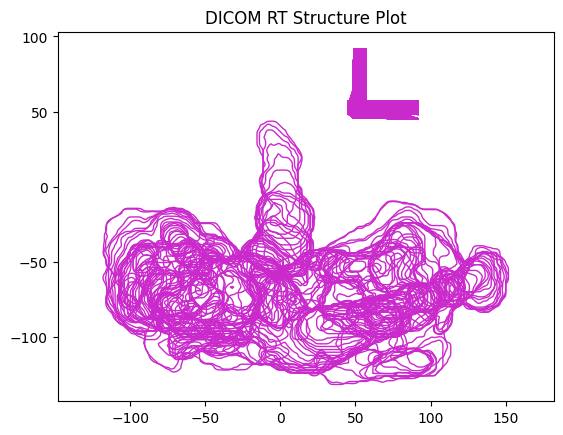

In [31]:
#plotting to show contour that needs to be removed for calculation
plot_rt_xy(example,10)

### Modifying RTST File

In [32]:
def modify_dicom_rt_structure(input_file, output_file, reference_num):
    # Read DICOM file
    ds = pydicom.dcmread(input_file)
    # Access the ContourSequence
    contour_sequences = ds.ROIContourSequence[reference_num].ContourSequence
    # Filter out the ContourSequences for the specific structure
    updated_contour_sequences = [contour for contour in contour_sequences if len(contour.ContourData) < 50000]
    # Update the original DICOM dataset
    ds.ROIContourSequence[reference_num].ContourSequence = updated_contour_sequences
    # Save the modified DICOM file
    ds.save_as(output_file)


def create_sigmoid(input_file,output_file,sig_num,bowel_num):
  # Read DICOM file
    ds = pydicom.dcmread(input_file)
    # Access the ContourSequence
    #creating sigmoid
    contour_sequences = ds.ROIContourSequence[bowel_num].ContourSequence
    # Filter out the ContourSequences for the specific structure
    updated_contour_sequences_sig = [contour_sequences[k] for k in range(len(contour_sequences)) if abs(contour_sequences[0].ContourData[2]) + contour_sequences[k].ContourData[2] <31 and contour_sequences[k].ContourData[0]<30]
    updated_contour_sequences_bowel = [contour_sequences[k] for k in range(len(contour_sequences)) if abs(contour_sequences[0].ContourData[2]) + contour_sequences[k].ContourData[2] >31 or contour_sequences[k].ContourData[0]>30]
    # Update the original DICOM dataset
    ds.ROIContourSequence[sig_num].ContourSequence = updated_contour_sequences_sig
    ds.ROIContourSequence[bowel_num].ContourSequence = updated_contour_sequences_bowel
    # Save the modified DICOM file
    ds.save_as(output_file)

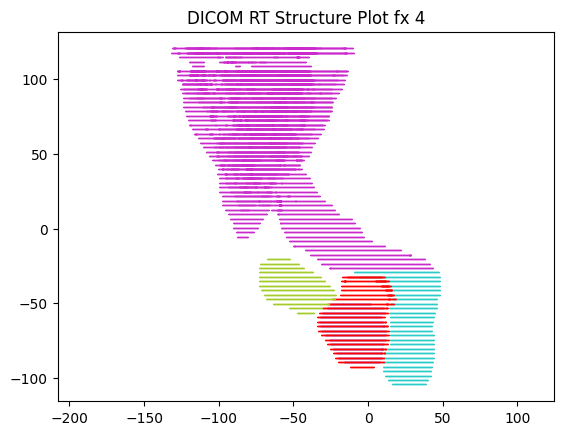

In [34]:


# Example usage with file_path set to the path of your DICOM RT Structure file
#modifying
fraction = 3
example = str(pt4_path + pt4_sorted[6+fraction*11]['File Name'])
new_structure_file = '/content/output_pt4.dcm'
modify_dicom_rt_structure(example, new_structure_file,9)

#plotting
plot_rt_structure('/content/output_pt4.dcm',4,fraction)
plot_rt_structure('/content/output_pt4.dcm',10,fraction)
plot_rt_structure('/content/output_pt4.dcm',3,fraction)
plot_rt_structure('/content/output_pt4.dcm',12,fraction)
plot_rt_structure('/content/output_pt4.dcm',5,fraction)

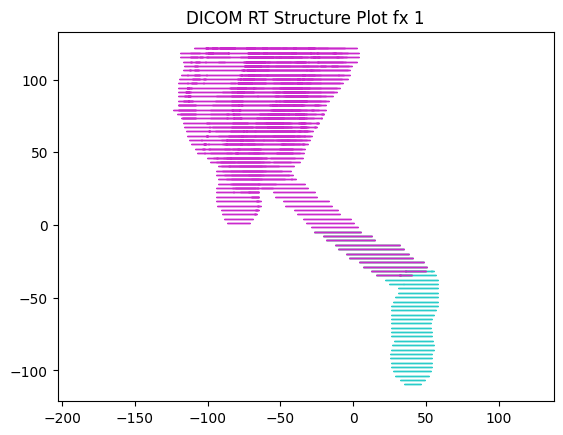

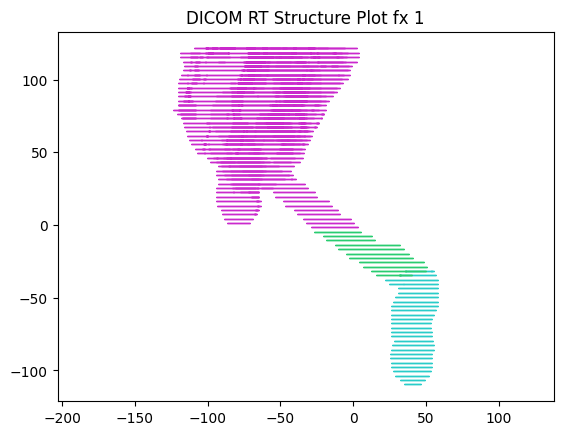

-------


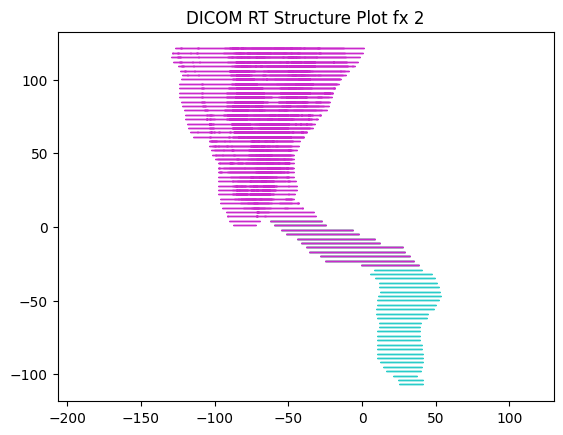

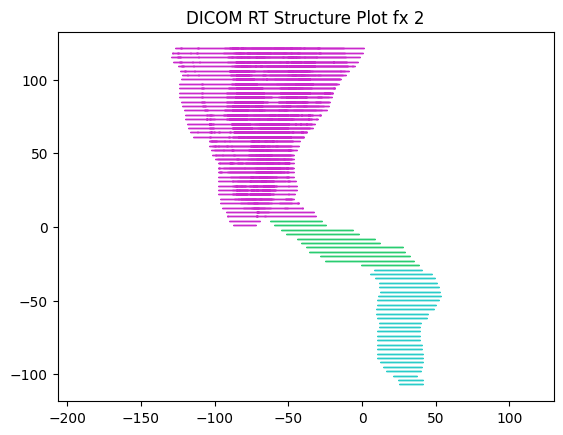

-------


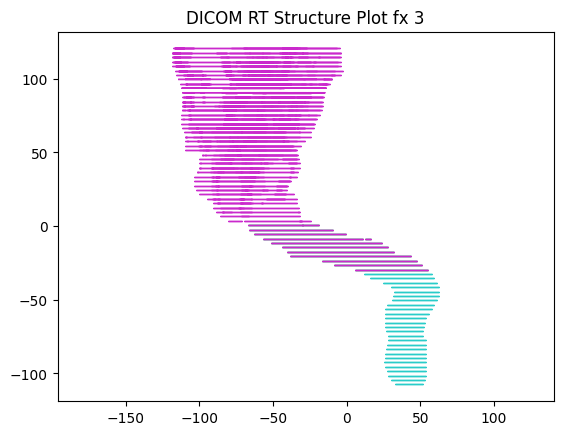

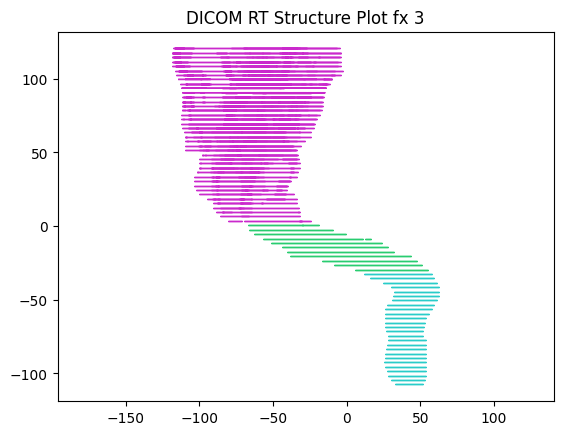

-------


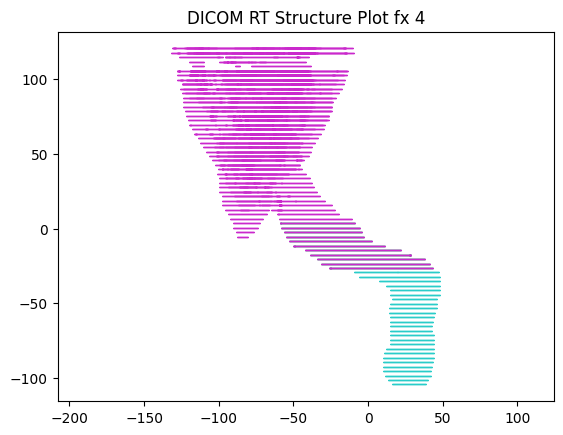

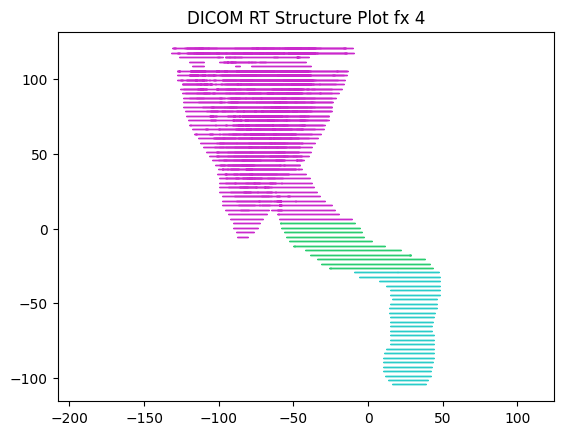

-------


In [36]:
# Example usage with file_path set to the path of your DICOM RT Structure file
#modifying
fraction = 1
for fraction in range(4):
  example = str(pt4_path + pt4_sorted[6+fraction*11]['File Name'])
  new_structure_file = '/content/output_pt4.dcm'
  modify_dicom_rt_structure(example, new_structure_file,9)

  #creating sigmoid
  new_structure_filev2 = '/content/output_pt4v2.dcm'
  create_sigmoid('/content/output_pt4.dcm', new_structure_filev2,5,9)

  #plotting
  plot_rt_structure('/content/output_pt4.dcm',4,fraction)
  plot_rt_structure('/content/output_pt4v2.dcm',6,fraction)
  plot_rt_structure('/content/output_pt4.dcm',10,fraction)
  plt.show()
  #plotting
  plot_rt_structure('/content/output_pt4v2.dcm',4,fraction)
  plot_rt_structure('/content/output_pt4v2.dcm',6,fraction)
  plot_rt_structure('/content/output_pt4v2.dcm',10,fraction)
  plt.show()
  print('-------')

## Statistics

### Function

In [37]:
##3-13
def clinical_pt4(rtst, rtdose):
  #find all calcs
  for structure in range(3,13):
    #print(structure)
    #if structure != 10:
      dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
      dvh.rx_dose =  60#Gy
      ## finding all goals
      #PTV
      if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
        PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
        PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
        PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
      #Rectum
      elif dvh.name == 'Rectum':
        RecV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
        RecV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
        RecV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
      #Bladder
      elif dvh.name == 'Bladder':
        BlaV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
        BlaV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
        BlaV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
      #Femur head & neck right
      elif dvh.name == 'Femur head & neck right':
        FRTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
        FRTmax = dvh.max #<5250cGy
      #Femur head & neck left
      elif dvh.name == 'Femur head & neck left':
        FLTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
        FLTmax = dvh.max #<5250cGy
    #Bowel
      elif dvh.name == 'Bowel':
        BowV4650 = dvh.volume_constraint((46.50), dose_units='Gy').value #2cm3
        Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
      elif dvh.name == 'Seminal vesicle':
        Sigmax = dvh.max #<5500cGy
  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])
  return dose_array

#REF PLan
def clinical_pt4REF(rtst, rtdose):
  #find all calcs
  for structure in range(3,14):
    #print(structure)
    #if structure != 10:
      dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
      dvh.rx_dose =  60#Gy
      ## finding all goals
      #PTV
      if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
        PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
        PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
        PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
      #Rectum
      elif dvh.name == 'Rectum':
        RecV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
        RecV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
        RecV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
      #Bladder
      elif dvh.name == 'Bladder':
        BlaV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
        BlaV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
        BlaV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
      #Femur head & neck right
      elif dvh.name == 'Femur head & neck right':
        FRTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
        FRTmax = dvh.max #<5250cGy
      #Femur head & neck left
      elif dvh.name == 'Femur head & neck left':
        FLTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
        FLTmax = dvh.max #<5250cGy
    #Bowel
      elif dvh.name == 'Bowel':
        BowV4650 = dvh.volume_constraint((46.50), dose_units='Gy').value #2cm3
        Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
      elif dvh.name == 'Seminal vesicle':
        Sigmax = dvh.max #<5500cGy

  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                    Sigmax])
  return dose_array


##3-13
def clinical_pt4REAL(rtst, rtdose):
  #find all calcs
  for structure in range(3,13):
    #if structure != 10:
      #print(structure)
      dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
      dvh.rx_dose =  3#Gy
      ## finding all goals
      #PTV
      if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
        PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
        PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
        PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
      #Rectum
      elif dvh.name == 'Rectum':
        RecV65 = 100*(dvh.V108.value/dvh.volume) #<15%
        RecV55 = 100*(dvh.V92.value/dvh.volume) #<25%
        RecV45 = 100*(dvh.V75.value/dvh.volume) #<45%
      #Bladder
      elif dvh.name == 'Bladder':
        BlaV65 = 100*(dvh.V108.value/dvh.volume) #<15%
        BlaV55 = 100*(dvh.V92.value/dvh.volume) #<25%
        BlaV45 = 100*(dvh.V75.value/dvh.volume) #<45%
      #Femur head & neck right
      elif dvh.name == 'Femur head & neck right':
        FRTV50 = 100*(dvh.V83.value/dvh.volume) # #<1%
        FRTmax = dvh.max #<5250cGy
      #Femur head & neck left
      elif dvh.name == 'Femur head & neck left':
        FLTV50 = 100*(dvh.V83.value/dvh.volume) # #<1%
        FLTmax = dvh.max #<5250cGy
    #Bowel
      elif dvh.name == 'Bowel':
        BowV4650 = dvh.V78.value #2cm3
        Bowmax = dvh.max # 5200cGy
    #Sigmoid colon
      elif dvh.name == 'Seminal vesicle':
        Sigmax = dvh.max #<5500cGy

  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])
  return dose_array

### Calcing

In [38]:
##3-13
## 3,4,8,9 fx not working
### sigmoid not included in structure files
pt4SCH_goals = np.zeros([16,])
pt4ADP_goals = np.zeros([16,])
pt4REAL_goals = np.zeros([16,])
pt4fraction_SCH = []
pt4fraction_ADP = []
pt4fraction_REAL = []
for fraction in range(20):
    #print(fraction_number)
    #updating file name
    structure_file = str(pt4_path + pt4_sorted[6+fraction*11]['File Name'])
    PLANdose_file = str(pt4_path + pt4_sorted[2+fraction*11]['File Name'])
    PLAN2dose_file = str(pt4_path + pt4_sorted[3+fraction*11]['File Name'])
    FRACdose_file = str(pt4_path + pt4_sorted[4+fraction*11]['File Name'])

    #modifying structure
    new_structure_file = '/content/output_pt4.dcm'
    modify_dicom_rt_structure(structure_file, new_structure_file,9)

    #creating sigmoid
    new_structure_filev2 = '/content/output_pt4v2.dcm'
    create_sigmoid('/content/output_pt4.dcm', new_structure_filev2,5,9)

    #calcing stats
    print(f'fration {fraction}')
    SCHPLAN = clinical_pt4(new_structure_filev2, PLANdose_file)
    ADPPLAN = clinical_pt4(new_structure_filev2, PLAN2dose_file)
    #REALPLAN = clinical_pt4REAL(structure_file, FRACdose_file)

    #saving stats
    pt4SCH_goals += SCHPLAN
    pt4fraction_SCH.append(SCHPLAN)
    pt4ADP_goals += ADPPLAN
    pt4fraction_ADP.append(ADPPLAN)
    #pt4REAL_goals += REALPLAN
    #pt4fraction_REAL.append(REALPLAN)
    #print(fraction)
    print('-----')

fration 0
-----
fration 1
-----
fration 2
-----
fration 3
-----
fration 4
-----
fration 5
-----
fration 6
-----
fration 7
-----
fration 8
-----
fration 9
-----
fration 10
-----
fration 11
-----
fration 12
-----
fration 13
-----
fration 14
-----
fration 15
-----
fration 16
-----
fration 17
-----
fration 18
-----
fration 19
-----


## Reference Calc

In [54]:
#creating dictionary
dsref = pydicom.dcmread(str(pt4_path + 'REF1'))
org_dic = {}
for i in (dsref.RTROIObservationsSequence):
  org_dic[i.ReferencedROINumber] = i.ROIObservationLabel
org_dic

{'1': 'Body',
 '2': 'CTV4400',
 '3': 'PTV6000',
 '4': 'PTV4400',
 '5': 'Bones',
 '6': 'Prostate',
 '7': 'Rectum',
 '8': 'Bladder',
 '9': 'Seminal vesicle',
 '10': 'Penile bulb',
 '11': 'Femur head & nec',
 '12': 'Femur head & nec',
 '13': 'Bowel',
 '14': 'Prost+SVfull',
 '15': '44 alone',
 '16': 'Couch Exterior',
 '17': 'Couch Interior'}

In [45]:
def create_sigmoid_REF(input_file,output_file,sig_num,bowel_num):
  # Read DICOM file
    ds = pydicom.dcmread(input_file)
    # Access the ContourSequence
    #creating sigmoid
    contour_sequences = ds.ROIContourSequence[bowel_num].ContourSequence
    # Filter out the ContourSequences for the specific structure
    updated_contour_sequences_sig = [contour_sequences[k] for k in range(len(contour_sequences)) if contour_sequences[k].ContourData[2] <279 and contour_sequences[k].ContourData[0]<50]
    updated_contour_sequences_bowel = [contour_sequences[k] for k in range(len(contour_sequences)) if contour_sequences[k].ContourData[2] >279 or contour_sequences[k].ContourData[0]>50]
    # Update the original DICOM dataset
    ds.ROIContourSequence[sig_num].ContourSequence = updated_contour_sequences_sig
    ds.ROIContourSequence[bowel_num].ContourSequence = updated_contour_sequences_bowel
    # Save the modified DICOM file
    ds.save_as(output_file)

first


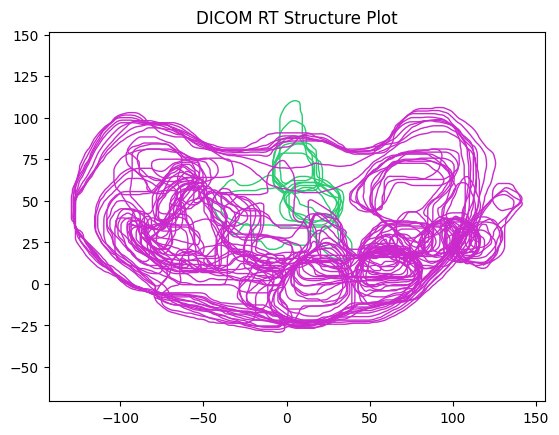

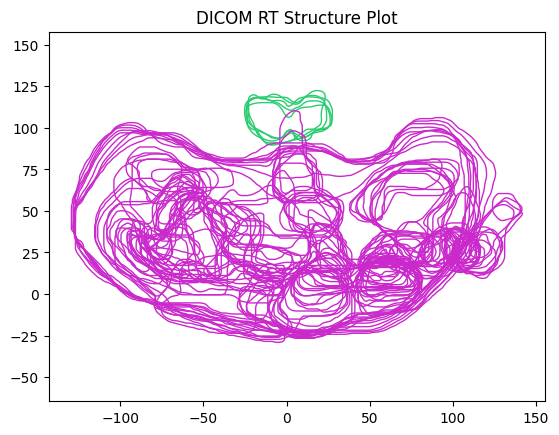

In [57]:
 #creating sigmoid
new_structure_ref = '/content/output_pt4_ref.dcm'
create_sigmoid_REF(REFstructure_file, new_structure_ref,8,12)

#plotting
plot_rt_xy('/content/output_pt4_ref.dcm',9)
plot_rt_xy('/content/output_pt4_ref.dcm',13)
plt.show()
plot_rt_xy(REFstructure_file,9)
plot_rt_xy(REFstructure_file,13)

In [58]:
##2-11
#files
REFstructure_file = str(pt4_path + 'REF1')
REFdose_file = str(pt4_path + 'REF0')

#solving
pt4REF = clinical_pt4REF('/content/output_pt4_ref.dcm', REFdose_file)

## Displaying Statistics

In [60]:
#naming arrays
location_names = np.array(['PTVV100','PTVV98','PTVmax',
                  'RectumV65','RectumV55','RectumV45',
                  'BladderV65','BladderV55','BladderV45',
                  'RT FemurV50', 'RT Femur max',
                  'LT FemurV50', 'LT Femur max',
                  'BowelV4650', 'Bowel max',
                  'Sigmoid Colon max'])
goal_names = np.array(['>=95%','>=98%','<=108%',
                       '<=15%','<=25%','<=45%',
                       '<=15%','<=25%','<=45%',
                       '<+1%', '<=5250cGy',
                       '<=1%', '<=5250cGy',
                       '<=2cc', '<=5200cGy',
                       '<=5500cGy'])

#averging stats
def avg_stats(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    #if i != 10 and i != 12 and i != 14:
      new_vals[i] = stats[i] / 20
  return new_vals

#averging stats
def avg_statsREAL(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    if i != 10 and i != 12 and i != 14:
      new_vals[i] = stats[i] / 20
  return new_vals

In [61]:
#calling
pt4SCH = avg_stats(pt4SCH_goals)
pt4ADP = avg_stats(pt4ADP_goals)
#pt4REAL = avg_statsREAL(pt4REAL_goals)


#dataframe
df_pt4 = pd.DataFrame({'Pt4 REF': pt4REF,
                       'Pt4 SCH': pt4SCH,
                      'Pt4 ADP': pt4ADP,
                      'Goals': goal_names},
                      location_names)
df_pt4

Pt4 REF     Pt4 SCH     Pt4 ADP      Goals
PTVV100             96.696453   74.407890   96.684733      >=95%
PTVV98              99.025183   80.458340   99.045803      >=98%
PTVmax             107.866667  106.852500  107.945833     <=108%
RectumV65            0.000000    0.000000    0.000000      <=15%
RectumV55            1.809846    0.541321    2.080175      <=25%
RectumV45           16.819498    4.962044   18.557643      <=45%
BladderV65           0.000000    0.000000    0.000000      <=15%
BladderV55           2.466429    2.442659    3.071350      <=25%
BladderV45          15.237051   16.252137   17.142703      <=45%
RT FemurV50          0.000000    0.000000    0.000000       <+1%
RT Femur max        25.220000   27.127000   31.431000  <=5250cGy
LT FemurV50          0.000000    0.000000    0.000000       <=1%
LT Femur max        25.940000   26.398500   29.241000  <=5250cGy
BowelV4650           0.075000    1.960312    0.069375      <=2cc
Bowel max           47.000000   47.734000   46.677500  <=5200cGy
Sigmoid Colon max   46.040000   52.693000   49.799000  <=5500cGy

## CSV Files

In [ ]:
# prompt: do what I did below but what the three fraction lists above
#building df
#pt4fraction_SCH_df = pd.DataFrame(pt4fraction_SCH).transpose()
#pt4fraction_ADP_df = pd.DataFrame(pt4fraction_ADP).transpose()
#pt4fraction_REAL_df = pd.DataFrame(pt4fraction_REAL).transpose()
#pt4_REF_df = pd.DataFrame(pt4REF)#.transpose()

#adding goal names
#pt4fraction_SCH_df.set_index(location_names, inplace=True)
#pt4fraction_ADP_df.set_index(location_names, inplace=True)
#pt4fraction_REAL_df.set_index(location_names, inplace=True)
#pt4_REF_df.set_index(location_names, inplace=True)

#saving dfs as csv files
#df_pt4.to_csv('/content/drive/My Drive/pt4_clinical_stats.csv')
#pt4fraction_SCH_df.to_csv('/content/drive/My Drive/pt4_fractional_stats_SCH.csv')
#pt4fraction_ADP_df.to_csv('/content/drive/My Drive/pt4_fractional_stats_ADP.csv')
#pt4fraction_REAL_df.to_csv('/content/drive/My Drive/pt4_fractional_stats_REAL.csv')
#pt4_REF_df.to_csv('/content/drive/My Drive/pt4_REF_stats.csv')

# Patient 5

In [62]:
pt5_path = '/content/drive/My Drive/DICOMData/Patient5/'

## DIR

In [63]:
#loading in DIR
pt5_DIR = pydicom.dcmread('/content/drive/My Drive/DICOMData/Patient5/DICOMDIR')

In [64]:
#Finding Dose, Structure, REG information
pt5_sorted = DIR_informaiton(file_list(pt5_DIR), pt5_DIR)

#delete extra files 9&21
del pt5_sorted[9]
del pt5_sorted[21]
pt5_sorted = {i: pt5_sorted[key] for i, key in enumerate(pt5_sorted)}
print(len(pt5_sorted))

#looking
fraction = 0
for i in range(fraction*11, fraction*11+11):
  print(i, pt5_sorted[i])

220
0 {'File Type': 'REG', 'Date': 20220912, 'Time': '145624.699', 'File Name': 'I11146', 'Delivery Method': 'N/A', 'Plan Type': 'N/A'}
1 {'File Type': 'REG', 'Date': 20220912, 'Time': '150735.085', 'File Name': 'I6220', 'Delivery Method': 'N/A', 'Plan Type': 'N/A'}
2 {'File Type': 'RTDOSE', 'Date': 20220912, 'Time': '144919', 'File Name': 'I6240', 'Delivery Method': 'PLAN', 'Plan Type': 'N/A'}
3 {'File Type': 'RTDOSE', 'Date': 20220912, 'Time': '145108', 'File Name': 'I6242', 'Delivery Method': 'PLAN', 'Plan Type': 'N/A'}
4 {'File Type': 'RTDOSE', 'Date': 20220912, 'Time': '150600', 'File Name': 'I6241', 'Delivery Method': 'FRACTION', 'Plan Type': 'N/A'}
5 {'File Type': 'RTDOSE', 'Date': 20220912, 'Time': '150744', 'File Name': 'I0', 'Delivery Method': 'FRACTION', 'Plan Type': 'N/A'}
6 {'File Type': 'RTSTRUCT', 'Date': 20220912, 'Time': '144840', 'File Name': 'I6301', 'Delivery Method': 'N/A', 'Plan Type': 'SCT/ADP0101'}
7 {'File Type': 'RTSTRUCT', 'Date': 20220912, 'Time': '144840', 

## DVH

Structure 7 has a volume of 0!


<ipython-input-3-458fbeeb6e9d>:35: RuntimeWarning: invalid value encountered in divide
  volume_percent = (volume_values_cumulative / total_volume) * 100


20220912
Structure 7 has a volume of 0!
20220912
Structure 7 has a volume of 0!
20220916
Structure 7 has a volume of 0!
20220916
Structure 7 has a volume of 0!
20220923
Structure 7 has a volume of 0!
20220923
Structure 7 has a volume of 0!
20221003
Structure 7 has a volume of 0!
20221003
Structure 7 has a volume of 0!
20221010
Structure 7 has a volume of 0!
20221010


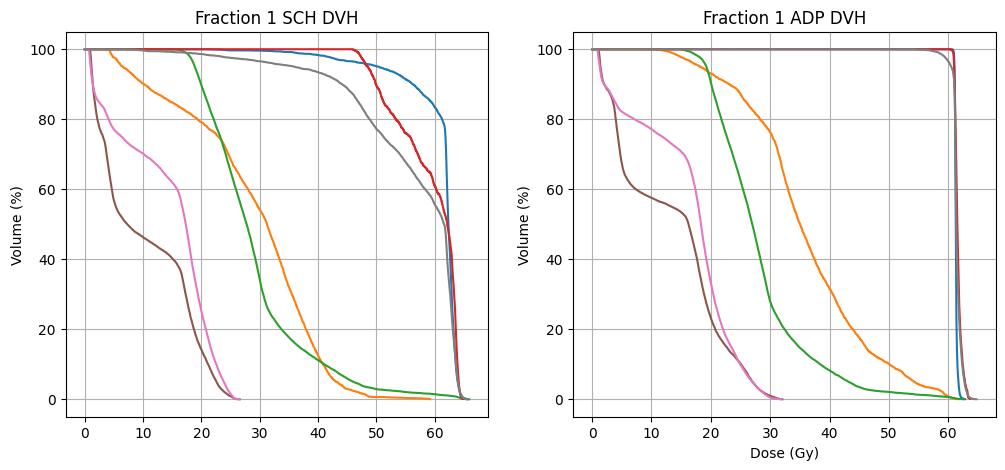

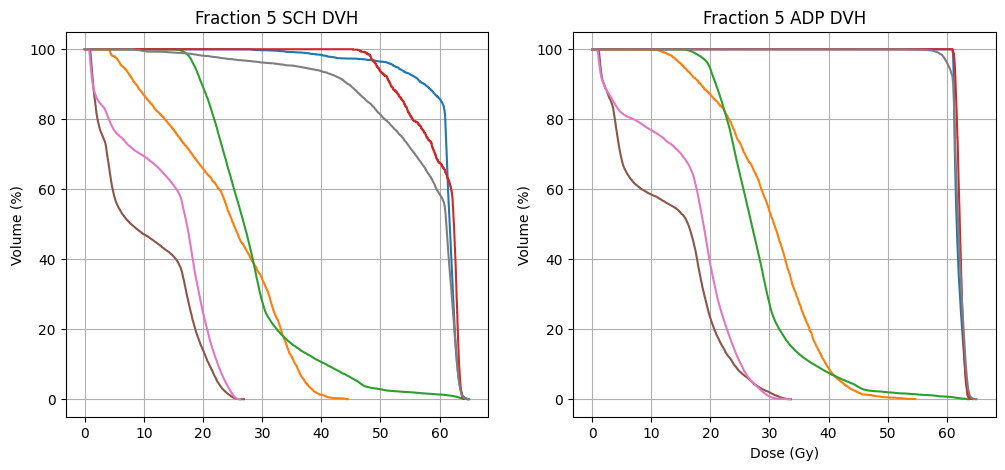

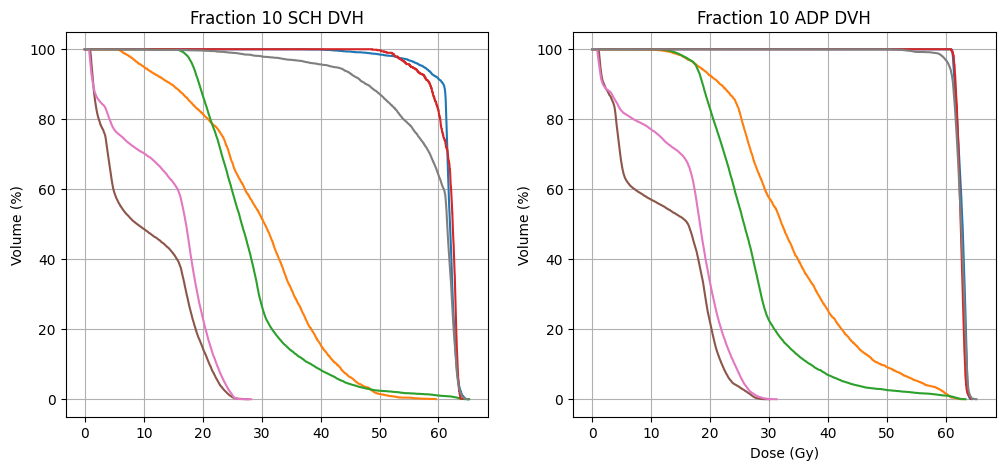

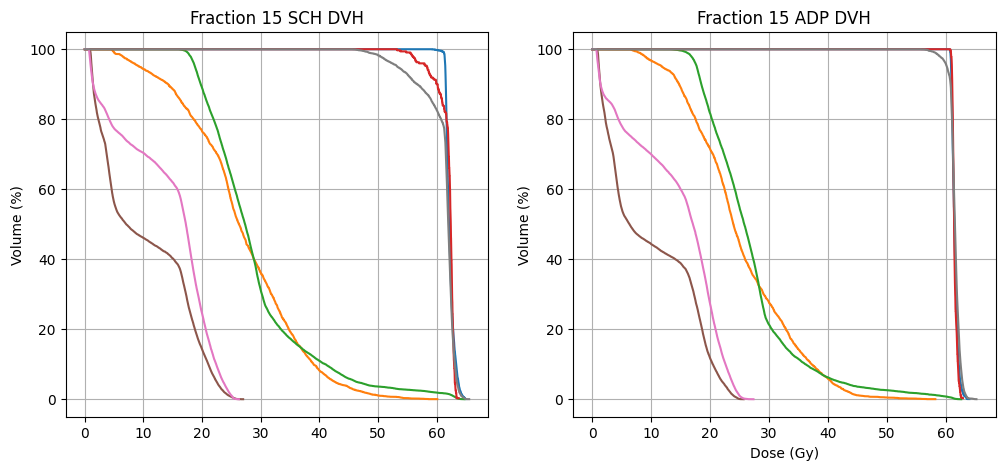

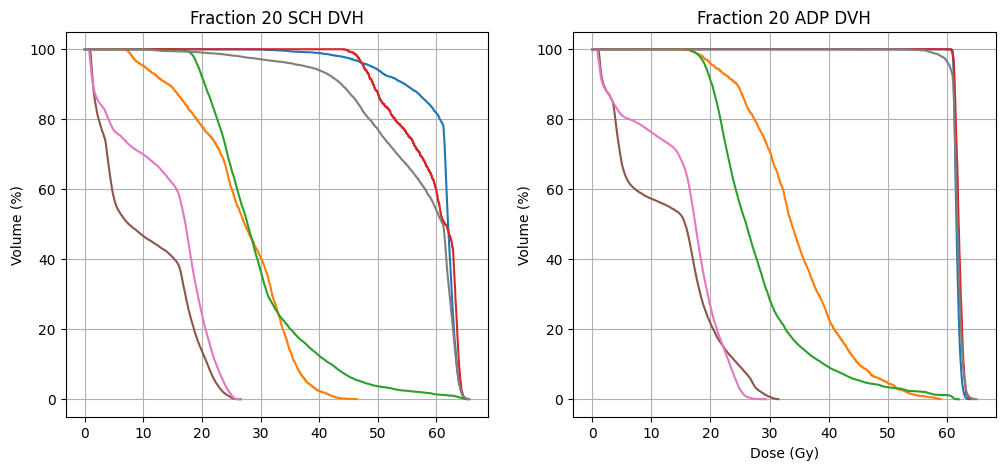

In [ ]:
for i in range(-1,21,5):
  #getting fx 1,5,10,15,20
  if i == -1:
    fraction = 0
  else:
    fraction = i

  #file names
  FRACdose_file = str(pt5_path + pt5_sorted[4+fraction*11]['File Name'])
  PLANdose_file = str(pt5_path + pt5_sorted[2+fraction*11]['File Name'])
  PLAN2dose_file = str(pt5_path + pt5_sorted[3+fraction*11]['File Name'])
  structure_file = str(pt5_path + pt5_sorted[7+fraction*11]['File Name'])
  RECstructure_file = str(pt5_path + pt5_sorted[10+fraction*11]['File Name'])

  fig, axs = plt.subplots(1, 2, figsize=(12,5))
  ## plotting
  #plotting scheduled plan
  for structure_id in range(3,13):
    if structure_id != 10:
      plt.subplot(1, 2, 1)
      plot_dvh(structure_file, PLANdose_file, structure_id)
  print(pt5_sorted[2+fraction*11]['Date'])
  # Customize the plot
  plt.ylabel('Volume (%)')
  plt.title(f'Fraction {fraction+1} SCH DVH')
  plt.grid(True)

  #plotting adaptive plan
  for structure_id in range(3,13):
    if structure_id != 10:
      plt.subplot(1, 2, 2)
      plot_dvh(structure_file, PLAN2dose_file, structure_id)
  print(pt5_sorted[3+fraction*11]['Date'])
  # Customize the plot
  plt.xlabel('Dose (Gy)')
  plt.ylabel('Volume (%)')
  plt.title(f'Fraction {fraction+1} ADP DVH')
  plt.grid(True)

## Structure Plotting

In [65]:
fraction = 2
example = str(pt5_path + pt5_sorted[6+fraction*11]['File Name'])

In [66]:
#creating dictionary
ds = pydicom.dcmread(example)
org_dic = {}
for i in (ds.RTROIObservationsSequence):
  org_dic[i.ReferencedROINumber] = i.ROIObservationLabel
org_dic

{'1': 'Body',
 '2': 'Bones',
 '3': 'Prostate',
 '4': 'Rectum',
 '5': 'Bladder',
 '6': 'Seminal vesicle',
 '7': 'Penile bulb',
 '8': 'Femur head & nec',
 '9': 'Femur head & nec',
 '10': 'Bowel',
 '11': 'CTV4400',
 '12': 'PTV6000',
 '13': 'PTV4400',
 '14': 'Hardware',
 '15': 'Prost+SVfull',
 '16': '44 alone',
 '17': 'Stainless_Steel1',
 '18': 'Couch Exterior',
 '19': 'Couch Interior'}

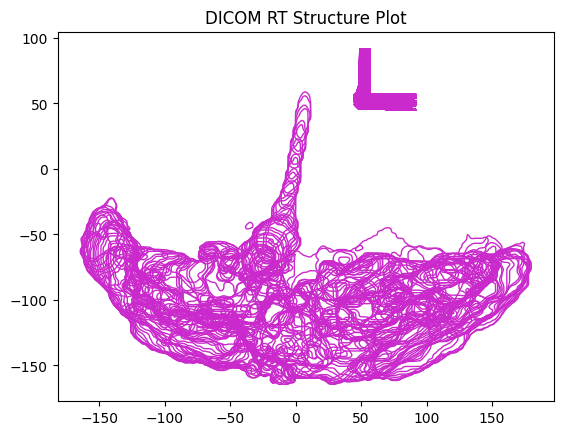

In [68]:
#contour showing error in contour
plot_rt_xy(example,10)
#plot_rt_xy(example,4)
#plot_rt_xy(example,6)

### Modifying

#### Functions

In [69]:
def modify_dicom_rt_structure(input_file, output_file, reference_num):
    # Read DICOM file
    ds = pydicom.dcmread(input_file)
    # Access the ContourSequence
    contour_sequences = ds.ROIContourSequence[reference_num].ContourSequence
    # Filter out the ContourSequences for the specific structure
    updated_contour_sequences = [contour for contour in contour_sequences if len(contour.ContourData) < 50000]
    # Update the original DICOM dataset
    ds.ROIContourSequence[reference_num].ContourSequence = updated_contour_sequences
    # Save the modified DICOM file
    ds.save_as(output_file)

def create_sigmoid(input_file,output_file,sig_num,bowel_num):
  # Read DICOM file
    ds = pydicom.dcmread(input_file)
    # Access the ContourSequence
    #creating sigmoid
    contour_sequences = ds.ROIContourSequence[bowel_num].ContourSequence
    # Filter out the ContourSequences for the specific structure
    updated_contour_sequences_sig = [contour_sequences[k] for k in range(len(contour_sequences)) if abs(contour_sequences[0].ContourData[2]) + contour_sequences[k].ContourData[2] <31 and contour_sequences[k].ContourData[0]<30]
    updated_contour_sequences_bowel = [contour_sequences[k] for k in range(len(contour_sequences)) if abs(contour_sequences[0].ContourData[2]) + contour_sequences[k].ContourData[2] >31 or contour_sequences[k].ContourData[0]>30]
    # Update the original DICOM dataset
    ds.ROIContourSequence[sig_num].ContourSequence = updated_contour_sequences_sig
    ds.ROIContourSequence[bowel_num].ContourSequence = updated_contour_sequences_bowel
    # Save the modified DICOM file
    ds.save_as(output_file)

#### Displaying new Sigmoid

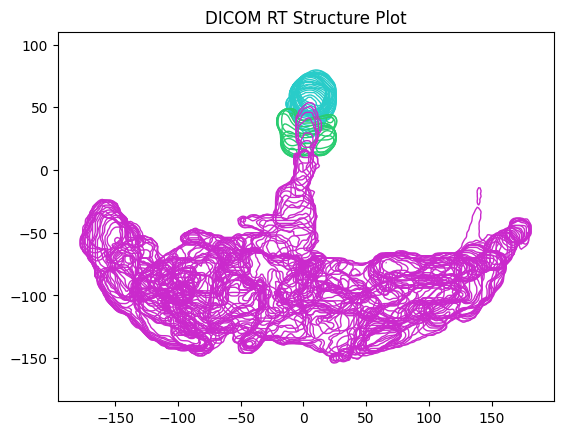

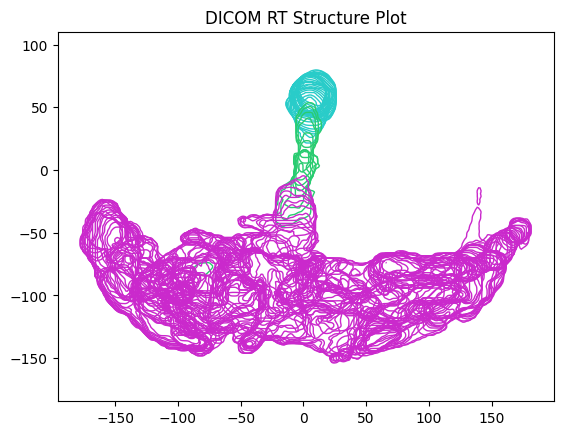

-------


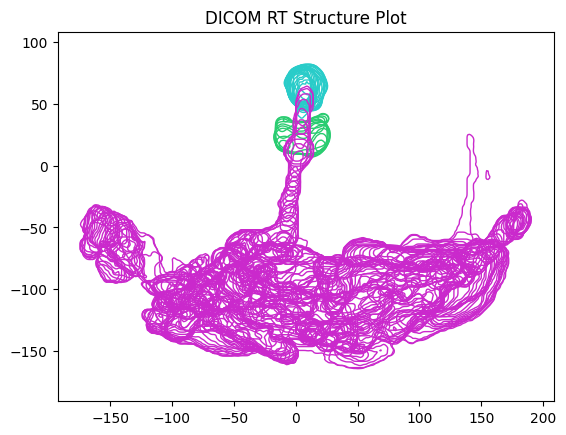

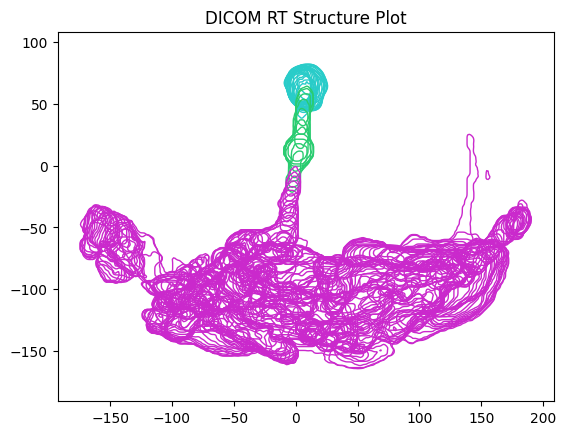

-------


In [71]:
# Example usage with file_path set to the path of your DICOM RT Structure file
#modifying
fraction = 1
for fraction in range(2):
  example = str(pt5_path + pt5_sorted[6+fraction*11]['File Name'])
  new_structure_file = '/content/output_pt5.dcm'
  modify_dicom_rt_structure(example, new_structure_file,9)

  #creating sigmoid
  new_structure_filev2 = '/content/output_pt5v2.dcm'
  create_sigmoid('/content/output_pt5.dcm', new_structure_filev2,5,9)

  #plotting
  plot_rt_xy('/content/output_pt5.dcm',4)
  plot_rt_xy('/content/output_pt5.dcm',6)
  plot_rt_xy('/content/output_pt5.dcm',10)
  plt.show()
  #plotting
  plot_rt_xy('/content/output_pt5v2.dcm',4)
  plot_rt_xy('/content/output_pt5v2.dcm',6)
  plot_rt_xy('/content/output_pt5v2.dcm',10)
  plt.show()
  print('-------')

## Statistics

### Function

In [72]:
##plans
def clinical_pt5(rtst, rtdose):
  #find all calcs
  for structure in range(3,13):
    #print(structure)
    #if structure != 10:
      dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
      dvh.rx_dose =  60#Gy
        ## finding all goals
        #PTV
      if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
        #print('ptv')
        PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
        PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
        PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
      #Rectum
      elif dvh.name == 'Rectum':
        #print('rec')
        RecV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
        RecV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
        RecV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
      #Bladder
      elif dvh.name == 'Bladder':
        #print('blad')
        BlaV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
        BlaV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
        BlaV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
      #Femur head & neck right
      elif dvh.name == 'Femur head & neck right':
        #print('rt fe')
        FRTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
        FRTmax = dvh.max #<5250cGy
      #Femur head & neck left
      elif dvh.name == 'Femur head & neck left':
        #print('lt fe')
        FLTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
        FLTmax = dvh.max #<5250cGy
      #Bowel
      elif dvh.name == 'Bowel':
        BowV4650 = dvh.volume_constraint((46.50), dose_units='Gy').value #2cm3
        Bowmax = dvh.max # 5200cGy
      #Sigmoid colon
      elif dvh.name == 'Seminal vesicle':#added sigmoid to Seminal vesicle structure set
        Sigmax = dvh.max #<5500cGy

  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])
  return dose_array

#reference plan
def clinical_pt5REF(rtst, rtdose):
  #find all calcs
  for structure in range(3,14):
    #print(structure)
    #if structure != 10:
      dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
      dvh.rx_dose =  60#Gy
        ## finding all goals
        #PTV
      if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
        #print('ptv')
        PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
        PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
        PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
      #Rectum
      elif dvh.name == 'Rectum':
        #print('rec')
        RecV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
        RecV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
        RecV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
      #Bladder
      elif dvh.name == 'Bladder':
        #print('blad')
        BlaV65 = 100*(dvh.volume_constraint(65, dose_units='Gy').value / dvh.volume) #<15%
        BlaV55 = 100*(dvh.volume_constraint(55, dose_units='Gy').value / dvh.volume) #<25%
        BlaV45 = 100*(dvh.volume_constraint(45, dose_units='Gy').value / dvh.volume) #<45%
      #Femur head & neck right
      elif dvh.name == 'Femur head & neck right':
        #print('rt fe')
        FRTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
        FRTmax = dvh.max #<5250cGy
      #Femur head & neck left
      elif dvh.name == 'Femur head & neck left':
        #print('lt fe')
        FLTV50 = 100*(dvh.volume_constraint(50, dose_units='Gy').value / dvh.volume) # #<1%
        FLTmax = dvh.max #<5250cGy
      #Bowel
      elif dvh.name == 'Bowel':
        #print('bow')
        BowV4650 = dvh.volume_constraint((46.50), dose_units='Gy').value #2cm3
        Bowmax = dvh.max # 5200cGy
      #Sigmoid colon
      elif dvh.name == 'Seminal vesicle':
        #print('sig')
        Sigmax = dvh.max #<5500cGy

  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,
                   BowV4650, Bowmax,
                   Sigmax])
  return dose_array

##fraction
def clinical_pt5REAL(rtst, rtdose):
  #find all calcs
  for structure in range(3,13):
    #print(structure)
    if structure != 10:
      dvh = dvhcalc.get_dvh(rtst, rtdose, structure)
      dvh.rx_dose =  3#Gy
        ## finding all goals
        #PTV
      if dvh.name == 'PTV6000' or dvh.name == 'PTV60':
        #print('ptv')
        PTVV100 = 100*(dvh.V100.value / dvh.volume) #>95%
        PTVV98 = 100*(dvh.V98.value / dvh.volume)  #>98%
        PTVmax = 100*(dvh.max / dvh.rx_dose)  #<=108%
      #Rectum
      elif dvh.name == 'Rectum':
        #print('rec')
        RecV65 = 100*(dvh.V108.value/dvh.volume) #<15%
        RecV55 = 100*(dvh.V92.value/dvh.volume) #<25%
        RecV45 = 100*(dvh.V75.value/dvh.volume) #<45%
      #Bladder
      elif dvh.name == 'Bladder':
        #print('blad')
        BlaV65 = 100*(dvh.V108.value/dvh.volume) #<15%
        BlaV55 = 100*(dvh.V92.value/dvh.volume) #<25%
        BlaV45 = 100*(dvh.V75.value/dvh.volume) #<45%
      #Femur head & neck right
      elif dvh.name == 'Femur head & neck right':
        #print('rt fe')
        FRTV50 = 100*(dvh.V83.value/dvh.volume) # #<1%
        FRTmax = dvh.max #<5250cGy
      #Femur head & neck left
      elif dvh.name == 'Femur head & neck left':
        #print('lt fe')
        FLTV50 = 100*(dvh.V83.value/dvh.volume) # #<1%
        FLTmax = dvh.max #<5250cGy
      #Bowel
      #elif dvh.name == 'Bowel':
      # print('bow')
        #BowV4650 = dvh.V78.value #2cm3
        #Bowmax = dvh.max # 5200cGy
      #Sigmoid colon
      elif dvh.name == 'Sigmoid colon':
        #print('sig')
        Sigmax = dvh.max #<5500cGy

  dose_array = np.array([PTVV100,PTVV98,PTVmax,
                   RecV65,RecV55,RecV45,
                   BlaV65,BlaV55,BlaV45,
                   FRTV50, FRTmax,
                   FLTV50, FLTmax,])
                   #BowV4650, Bowmax,
                   #Sigmax])
  return dose_array

### Calcing

In [73]:
##fraction 2,4,6 won't work
pt5SCH_goals = np.zeros([16,])
pt5ADP_goals = np.zeros([16,])
pt5REAL_goals = np.zeros([16,])
pt5fraction_SCH = []
pt5fraction_ADP = []
pt5fraction_REAL = []
for fraction in range(20):
  #if fraction != 2 and fraction != 4 and fraction != 6:
    #print(fraction_number)
    #updating file name
    structure_file = str(pt5_path + pt5_sorted[6+fraction*11]['File Name'])
    PLANdose_file = str(pt5_path + pt5_sorted[2+fraction*11]['File Name'])
    PLAN2dose_file = str(pt5_path + pt5_sorted[3+fraction*11]['File Name'])
    FRACdose_file = str(pt5_path + pt5_sorted[4+fraction*11]['File Name'])

    #modifying structure
    new_structure_file = '/content/output_pt5.dcm'
    modify_dicom_rt_structure(structure_file, new_structure_file,9)

    #creating sigmoid
    new_structure_filev2 = '/content/output_pt5v2.dcm'
    create_sigmoid('/content/output_pt5.dcm', new_structure_filev2,5,9)

    #calcing stats
    print(f'fraction {fraction}')
    SCHPLAN = clinical_pt5(new_structure_filev2, PLANdose_file)
    print('SCH')
    ADPPLAN = clinical_pt5(new_structure_filev2, PLAN2dose_file)
    print('ADP')
    #REALPLAN = clinical_pt5REAL(structure_file, FRACdose_file)

    #saving stats
    pt5SCH_goals += SCHPLAN
    pt5fraction_SCH.append(SCHPLAN)
    pt5ADP_goals += ADPPLAN
    pt5fraction_ADP.append(ADPPLAN)
    #pt5REAL_goals += REALPLAN
    #pt5fraction_REAL.append(REALPLAN)
    #print(fraction)
    print('----')

fraction 0
SCH
ADP
----
fraction 1
SCH
ADP
----
fraction 2
SCH
ADP
----
fraction 3
SCH
ADP
----
fraction 4
SCH
ADP
----
fraction 5
SCH
ADP
----
fraction 6
SCH
ADP
----
fraction 7
SCH
ADP
----
fraction 8
SCH
ADP
----
fraction 9
SCH
ADP
----
fraction 10
SCH
ADP
----
fraction 11
SCH
ADP
----
fraction 12
SCH
ADP
----
fraction 13
SCH
ADP
----
fraction 14
SCH
ADP
----
fraction 15
SCH
ADP
----
fraction 16
SCH
ADP
----
fraction 17
SCH
ADP
----
fraction 18
SCH
ADP
----
fraction 19
SCH
ADP
----


### Reference Calc

In [74]:
#creating dictionary
dsref = pydicom.dcmread(str(pt5_path + 'REF1'))
org_dic = {}
for i in (dsref.RTROIObservationsSequence):
  org_dic[i.ReferencedROINumber] = i.ROIObservationLabel
org_dic

{'1': 'Body',
 '2': 'CTV4400',
 '3': 'PTV6000',
 '4': 'PTV4400',
 '5': 'Bones',
 '6': 'Prostate',
 '7': 'Rectum',
 '8': 'Bladder',
 '9': 'Seminal vesicle',
 '10': 'Penile bulb',
 '11': 'Femur head & nec',
 '12': 'Femur head & nec',
 '13': 'Bowel',
 '14': 'Hardware',
 '15': 'Prost+SVfull',
 '16': '44 alone',
 '17': 'Stainless_Steel1',
 '18': 'Couch Exterior',
 '19': 'Couch Interior'}

In [75]:
def create_sigmoid_REF(input_file,output_file,sig_num,bowel_num):
  # Read DICOM file
    ds = pydicom.dcmread(input_file)
    # Access the ContourSequence
    #creating sigmoid
    contour_sequences = ds.ROIContourSequence[bowel_num].ContourSequence
    # Filter out the ContourSequences for the specific structure
    updated_contour_sequences_sig = [contour_sequences[k] for k in range(len(contour_sequences)) if contour_sequences[k].ContourData[2] <-89 and contour_sequences[k].ContourData[0]<50]
    updated_contour_sequences_bowel = [contour_sequences[k] for k in range(len(contour_sequences)) if contour_sequences[k].ContourData[2] >-89 or contour_sequences[k].ContourData[0]>50]
    # Update the original DICOM dataset
    ds.ROIContourSequence[sig_num].ContourSequence = updated_contour_sequences_sig
    ds.ROIContourSequence[bowel_num].ContourSequence = updated_contour_sequences_bowel
    # Save the modified DICOM file
    ds.save_as(output_file)

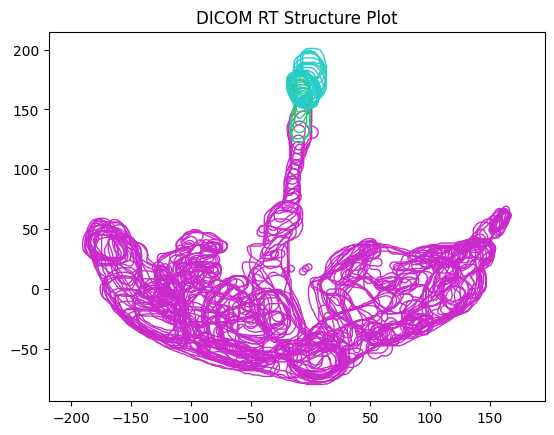

In [77]:
#creating sigmoid
new_structure_ref = '/content/output_pt5_ref.dcm'
create_sigmoid_REF(str(pt5_path + 'REF1'), new_structure_ref,8,12)

#plotting
plot_rt_xy('/content/output_pt5_ref.dcm',13)
plot_rt_xy('/content/output_pt5_ref.dcm',9)
plot_rt_xy('/content/output_pt5_ref.dcm',7)

In [78]:
##2-11
#files
REFstructure_file = str(pt5_path + 'REF1')
REFdose_file = str(pt5_path + 'REF0')

#solving
pt5REF = clinical_pt5REF(new_structure_ref, REFdose_file)

## Displaying Statistics

In [80]:
#naming arrays
location_names = np.array(['PTVV100','PTVV98','PTVmax',
                  'RectumV65','RectumV55','RectumV45',
                  'BladderV65','BladderV55','BladderV45',
                  'RT FemurV50', 'RT Femur max',
                  'LT FemurV50', 'LT Femur max',
                  'BowelV4650', 'Bowel max',
                  'Sigmoid Colon max'])
goal_names = np.array(['>=95%','>=98%','<=108%',
                       '<=15%','<=25%','<=45%',
                       '<=15%','<=25%','<=45%',
                       '<+1%', '<=5250cGy',
                       '<=1%', '<=5250cGy',
                       '<=2cc', '<=5200cGy',
                       '<=5500cGy'])


#averging stats
def avg_stats(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    #if i != 10 and i != 12 and i != 14:
      new_vals[i] = stats[i] / 20
  return new_vals

#averging stats
def avg_statsREAL(stats):
  new_vals = np.copy(stats)
  for i in range(len(stats)):
    if i != 10 and i != 12 and i != 14:
      new_vals[i] = stats[i] / 20
  return new_vals

In [81]:
#calling
pt5SCH = avg_stats(pt5SCH_goals)
pt5ADP = avg_stats(pt5ADP_goals)
#pt5REAL = avg_statsREAL(pt5REAL_goals)

#dataframe
df_pt5 = pd.DataFrame({'Pt5 REF': pt5REF,
                       'Pt5 SCH': pt5SCH,
                      'Pt5 ADP': pt5ADP,
                      'Goals': goal_names},
                      location_names)
df_pt5

Pt5 REF     Pt5 SCH     Pt5 ADP      Goals
PTVV100             96.438356   58.621984   96.311299      >=95%
PTVV98              98.858447   62.319122   98.443721      >=98%
PTVmax             108.166667  108.947500  108.443333     <=108%
RectumV65            0.000000    0.000000    0.000000      <=15%
RectumV55            0.000000    0.110385    0.859864      <=25%
RectumV45            0.905433    0.907328    5.584223      <=45%
BladderV65           0.000000    0.061258    0.000000      <=15%
BladderV55           0.182419    2.730666    1.643813      <=25%
BladderV45           1.189526    6.627236    4.101574      <=45%
RT FemurV50          0.000000    0.000000    0.000000       <+1%
RT Femur max        25.830000   26.737500   29.724000  <=5250cGy
LT FemurV50          0.000000    0.000000    0.000000       <=1%
LT Femur max        25.890000   26.877500   29.806000  <=5250cGy
BowelV4650           0.000000    1.039687    0.000937      <=2cc
Bowel max           45.780000   47.485000   45.391000  <=5200cGy
Sigmoid Colon max   43.630000   45.687500   48.460500  <=5500cGy

## CSV Files

In [ ]:
# prompt: do what I did below but what the three fraction lists above
#building df
#pt5fraction_SCH_df = pd.DataFrame(pt5fraction_SCH).transpose()
#pt5fraction_ADP_df = pd.DataFrame(pt5fraction_ADP).transpose()
#pt5fraction_REAL_df = pd.DataFrame(pt5fraction_REAL).transpose()
#pt5_REF_df = pd.DataFrame(pt5REF)#.transpose()

#adding goal names
#pt5fraction_SCH_df.set_index(location_names, inplace=True)
#pt5fraction_ADP_df.set_index(location_names, inplace=True)
#pt5fraction_REAL_df.set_index(location_names, inplace=True)
#pt5_REF_df.set_index(location_names, inplace=True)

#saving dfs as csv files
#df_pt5.to_csv('/content/drive/My Drive/pt5_clinical_stats.csv')
#pt5fraction_SCH_df.to_csv('/content/drive/My Drive/pt5_fractional_stats_SCH.csv')
#pt5fraction_ADP_df.to_csv('/content/drive/My Drive/pt5_fractional_stats_ADP.csv')
#pt5fraction_REAL_df.to_csv('/content/drive/My Drive/pt5_fractional_stats_REAL.csv')
#pt5_REF_df.to_csv('/content/drive/My Drive/pt5_REF_stats.csv')

# Compiling Statistics

In [105]:
#naming arrays
location_names = np.array(['PTVV100','PTVV98','PTVmax',
                  'RectumV65','RectumV55','RectumV45',
                  'BladderV65','BladderV55','BladderV45',
                  'RT FemurV50', 'RT Femur max',
                  'LT FemurV50', 'LT Femur max',
                  'BowelV4650', 'Bowel max',
                  'Sigmoid Colon max'])

goal_names = np.array(['>=95%','>=98%','<=108%',
                       '<=15%','<=25%','<=45%',
                       '<=15%','<=25%','<=45%',
                       '<+1%', '<=52.50Gy',
                       '<=1%', '<=52.50Gy',
                       '<=2cc', '<=52.00Gy',
                       '<=55.00Gy'])

In [106]:
df_final = pd.DataFrame({'Pt1 SCH': np.round(pt1SCH,2),
                      'Pt1 ADP': np.round(pt1ADP,2),
                      'Pt2 SCH': np.round(pt2SCH,2),
                      'Pt2 ADP': np.round(pt2ADP,2),
                      'Pt3 SCH': np.round(pt3SCH,2),
                      'Pt3 ADP': np.round(pt3ADP,2),
                      'Pt4 SCH': np.round(pt4SCH,2),
                      'Pt4 ADP': np.round(pt4ADP,2),
                      'Pt5 SCH': np.round(pt5SCH,2),
                      'Pt5 ADP': np.round(pt5ADP,2),
                      'Goals': goal_names
                    }, location_names)
df_final

Pt1 SCH  Pt1 ADP  Pt2 SCH  Pt2 ADP  Pt3 SCH  Pt3 ADP  \
PTVV100              81.14    95.67    80.78    97.75    86.24    96.76   
PTVV98               90.39    98.61    86.17    99.43    89.75    99.08   
PTVmax              106.65   106.82   107.97   107.58   107.35   108.29   
RectumV65             0.00     0.00     0.00     0.00     0.00     0.00   
RectumV55             4.46     3.63     2.73     5.03     7.25     2.01   
RectumV45            12.90    13.99     7.57    11.20    17.30     9.79   
BladderV65            0.00     0.00     0.00     0.00     0.00     0.00   
BladderV55            8.58     3.60     1.88     2.86     3.39     3.31   
BladderV45           17.51    12.13     4.31     6.00    15.78    15.77   
RT FemurV50           0.00     0.00     0.00     0.00     0.00     0.00   
RT Femur max         27.39    28.12    20.99    21.80    37.06    34.58   
LT FemurV50           0.00     0.00     0.00     0.00     0.00     0.00   
LT Femur max         29.12    28.22    22.92    23.25    30.98    36.62   
BowelV4650            0.11     0.19     0.00     0.00     0.24     0.03   
Bowel max            32.78    37.98     2.15     2.48    47.80    47.20   
Sigmoid Colon max    53.71    52.42     9.30     4.83    45.59    46.04   

                   Pt4 SCH  Pt4 ADP  Pt5 SCH  Pt5 ADP      Goals  
PTVV100              74.41    96.68    58.62    96.31      >=95%  
PTVV98               80.46    99.05    62.32    98.44      >=98%  
PTVmax              106.85   107.95   108.95   108.44     <=108%  
RectumV65             0.00     0.00     0.00     0.00      <=15%  
RectumV55             0.54     2.08     0.11     0.86      <=25%  
RectumV45             4.96    18.56     0.91     5.58      <=45%  
BladderV65            0.00     0.00     0.06     0.00      <=15%  
BladderV55            2.44     3.07     2.73     1.64      <=25%  
BladderV45           16.25    17.14     6.63     4.10      <=45%  
RT FemurV50           0.00     0.00     0.00     0.00       <+1%  
RT Femur max         27.13    31.43    26.74    29.72  <=52.50Gy  
LT FemurV50           0.00     0.00     0.00     0.00       <=1%  
LT Femur max         26.40    29.24    26.88    29.81  <=52.50Gy  
BowelV4650            1.96     0.07     1.04     0.00      <=2cc  
Bowel max            47.73    46.68    47.48    45.39  <=52.00Gy  
Sigmoid Colon max    52.69    49.80    45.69    48.46  <=55.00Gy

### SCH vs ADP

In [109]:
#getting sum
SUM_REF = np.round(pt1REF) + np.round(pt2REF) + np.round(pt3REF) + np.round(pt4REF) + np.round(pt5REF)
SUM_SCH = np.round(pt1SCH) + np.round(pt2SCH) + np.round(pt3SCH) + np.round(pt4SCH) + np.round(pt5SCH)
SUM_ADP = np.round(pt1ADP) + np.round(pt2ADP) + np.round(pt3ADP) + np.round(pt4ADP) + np.round(pt5ADP)

#getting averages
avg_REF = SUM_REF / 5
avg_SCH = SUM_SCH / 5
avg_ADP = SUM_ADP / 5

In [110]:
#Summing
df_final = pd.DataFrame({'REF': np.round(avg_REF,2),
                         'SCH': np.round(avg_SCH,2),
                      'ADP': np.round(avg_ADP,2),
                      'Goals': goal_names
                    }, location_names)
df_final

REF    SCH    ADP      Goals
PTVV100             96.0   76.2   96.8      >=95%
PTVV98              98.8   81.6   98.8      >=98%
PTVmax             107.6  107.6  107.8     <=108%
RectumV65            0.0    0.0    0.0      <=15%
RectumV55            2.8    3.0    2.8      <=25%
RectumV45           11.4    8.8   12.0      <=45%
BladderV65           0.0    0.0    0.0      <=15%
BladderV55           2.2    3.8    3.0      <=25%
BladderV45          10.4   12.2   11.0      <=45%
RT FemurV50          0.0    0.0    0.0       <+1%
RT Femur max        27.0   27.8   29.2  <=52.50Gy
LT FemurV50          0.0    0.0    0.0       <=1%
LT Femur max        27.0   27.2   29.4  <=52.50Gy
BowelV4650           0.0    0.6    0.0      <=2cc
Bowel max           35.8   35.6   35.8  <=52.00Gy
Sigmoid Colon max   38.2   41.6   40.2  <=55.00Gy

PTV values have much better coverage on the ADP plans as expected, with V100 and V98 around a 20% and 12% increase resepctivly. In addition, we see a lower percentage of dose delivered to the OARs, with the exception of Rectum V45. All OAR doses are well within their resepctive tolerances.